In [1]:
import torch
torch.set_float32_matmul_precision('medium')
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchvision import models
from torchvision import transforms
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
import tensorboard
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [2]:
print(torch.__version__)
print("Is GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

2.6.0+cu124
Is GPU Available: True
GPU Name: NVIDIA H100 80GB HBM3


In [3]:
# define dataset
class RosetteDataSet(Dataset):
    def __init__(self, image_dir, labels_file, split='train', transform=None, target='n_arms'):
        """
        Args:
            image_dir (string): Directory with subfolders ('train', 'val', 'test') containing images.
            csv_file (string): CSV file containing image filenames and labels.
            split (string): Which data split to use ('train', 'val', 'test').
            transform (callable, optional): Optional transform to be applied on a sample.
            target (string): ['n_arms', 'rho_eff', 'sa_eff']
        """
        self.image_dir = os.path.join(image_dir, split)  # Select the correct subfolder (train/val/test)
        self.labels = pd.read_csv(labels_file)
        self.labels = self.labels[self.labels['split'] == split].reset_index(drop=True)
        self.label_mapping = {
            '4': 0,
            '5': 1,
            '6': 2,
            '7': 3,
            '8': 4,
            '9': 5,
            '10': 6
        }
        self.transform = transform
        self.target = target

    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.labels)

    def __getitem__(self, idx):
        """Load an image and its corresponding label(s)"""
        row = self.labels.iloc[idx]
        img_name = row['filename']  # Get the image filename
        img_path = os.path.join(self.image_dir, img_name)  # Construct the full image path
        image = Image.open(img_path)
        # Classification label (e.g. n_arms)
        label_str = str(row['n_arms'])  # ensure it's a string
        n_arms_labels = torch.tensor(self.label_mapping[label_str], dtype=torch.long)
        # Regression targets
        regression_targets = torch.tensor([row['rho_eff'], row['sa_eff']], dtype=torch.float32)
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        return image, n_arms_labels, regression_targets

In [4]:
labels_file = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000_default_split/labels.csv'
labels = pd.read_csv(labels_file)
labels.head()

,filename,split,n_arms,rho_eff,sa_eff
0,ros-projection-010913-002-default.png,test,5,0.015800,0.166602
1,ros-projection-016265-058-default.png,test,5,0.057668,0.324473
2,ros-projection-001142-087-default.png,test,4,0.014152,0.147579
3,ros-projection-017988-092-default.png,test,5,0.100758,0.443553
4,ros-projection-057113-091-default.png,test,9,0.026300,0.280913


In [5]:
labels.shape

(7000, 5)

# RosetteDataModule: handles loading/splitting data

In [1]:
class RosetteDataModule(pl.LightningDataModule):
    def __init__(self, image_dir, labels_file, batch_size, target, transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.labels_file = labels_file
        self.batch_size = batch_size
        self.target = target
        self.transform = transform

    def setup(self, stage=None):
        self.train_dataset = RosetteDataSet(self.image_dir, self.labels_file, split='train', transform=self.transform, target=self.target)
        self.val_dataset = RosetteDataSet(self.image_dir, self.labels_file, split='val', transform=self.transform, target=self.target)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

NameError: name 'pl' is not defined

# RosetteModel: LightningModule for one task

In [7]:
class RosetteModel(pl.LightningModule):
    def __init__(self, task='classification', 
                 num_classes=5, 
                 lr=1e-4, 
                 target='rho_eff', 
                 weights=models.ResNet18_Weights.DEFAULT):
        super().__init__()
        self.save_hyperparameters()
        self.task = task
        self.lr = lr
        self.target = target
        # self.backbone = models.resnet18(pretrained=True)
        self.backbone = models.resnet18(weights=weights)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 1 if task == 'regression' else num_classes)
        if task == 'classification':
            self.loss_fn = nn.CrossEntropyLoss()
        elif task == 'regression':
            self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        x, class_label, reg_target = batch
        if self.task == 'classification':
            y_hat = self(x)
            loss = self.loss_fn(y_hat, class_label)
        elif self.task == 'regression':
            y_hat = self(x)
            # Choose target from regression vector
            target_idx = 0 if self.target == "rho_eff" else 1
            y = reg_target[:, target_idx].unsqueeze(1)
            loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, class_label, reg_target = batch
        if self.task == "classification":
            y_hat = self(x)
            loss = self.loss_fn(y_hat, class_label)
            preds = torch.argmax(y_hat, dim=1)
            acc = (preds == class_label).float().mean()
            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)
            # store for confusion matrix
            self.val_preds_list.append(preds.cpu())
            self.val_targets_list.append(class_label.cpu())
            return {"preds": preds.cpu(), "targets": class_label.cpu()}
    
        elif self.task == "regression":
            y_hat = self(x)
            target_idx = 0 if self.target == "rho_eff" else 1
            y = reg_target[:, target_idx].unsqueeze(1)
            loss = self.loss_fn(y_hat, y)
            mae = torch.nn.functional.l1_loss(y_hat, y)  # Optional: add MAE as metric
            self.log("val_loss", loss, prog_bar=True)
            self.log("val_mae", mae, prog_bar=True)    
            self.val_preds_list.append(y_hat.cpu())
            self.val_targets_list.append(y.cpu())
            return {"preds": y_hat.cpu(), "targets": y.cpu()}

    def on_validation_epoch_start(self):
        # Clear lists before each validation epoch
        self.val_preds_list = []
        self.val_targets_list = []

    def on_validation_epoch_end(self):
        # Concatenate results for full epoch
        self.val_preds = torch.cat(self.val_preds_list).numpy()
        self.val_targets = torch.cat(self.val_targets_list).numpy()

    # def test_step(self, batch, batch_idx):
    #     pass

    # def predict_step(self):
    #     pass
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Run training for each task

## a) Predict n_arms (classification)

In [30]:
# setup trainer 
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000_default_split'
num_classes = len(labels['n_arms'].unique())
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = 'resnet-18-n1000-default-n_arms-tb'
csv_log_name = 'resnet-18-n1000-default-n_arms-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])
dm_class = RosetteDataModule(data_dir, labels_file, batch_size=32, target="n_arms", transform=transform)
model_class = RosetteModel(task='classification', num_classes=num_classes, lr=2e-7)
trainer = Trainer(max_epochs=1000, 
                  accelerator="auto",
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=False)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [31]:
# train model
trainer.fit(model_class, dm_class)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-45d3f099-7580-0654-d900-8a6ccba6e0a2]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.720    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_datalo

Plot validation results

Index(['epoch', 'step', 'train_loss', 'val_acc', 'val_loss'], dtype='object')


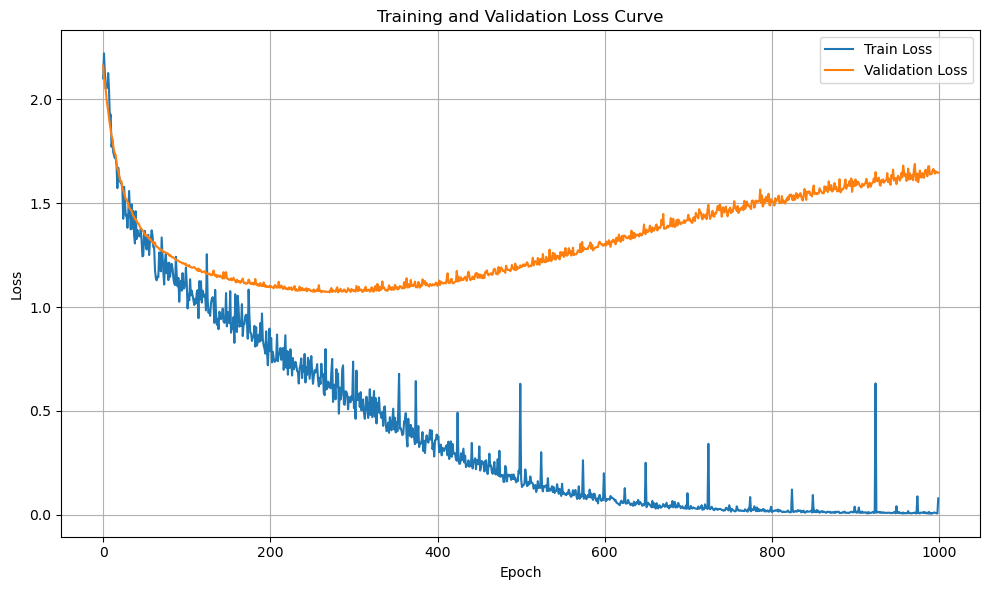

In [32]:
# plot the loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/resnet-18-n1000-default-n_arms-csv/version_29/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Drop the 'step' column
metrics_df = metrics_df.drop(columns=['step'])
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
    'val_acc': 'mean'       # Take the mean of the validation accuracy over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')

if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

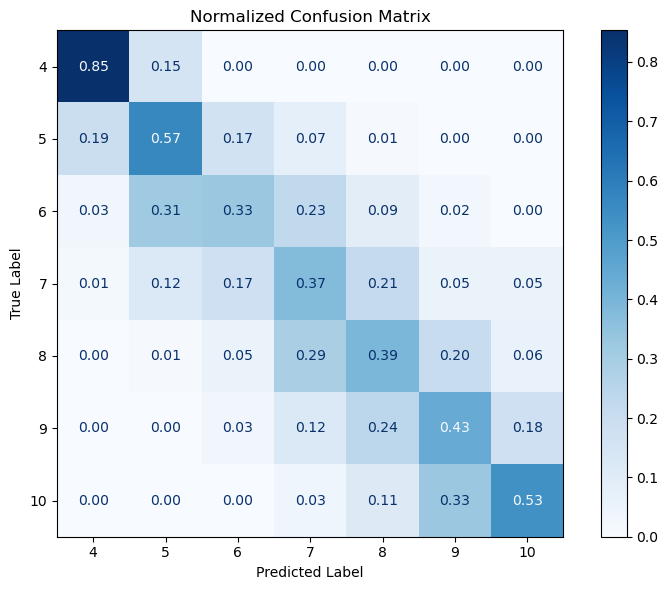

In [33]:
# # run validation
# val_results = trainer.validate(model_class, datamodule=dm_class)
# print(val_results)

# Extract predictions and targets from the model instance
preds = model_class.val_preds
targets = model_class.val_targets
# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')
# Plot the confusion matrix
class_labels = ['4', '5', '6', '7', '8', '9', '10']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# # Original class labels as strings
# class_labels = ['4', '5', '6', '7', '8', '9', '10']

# # Put model in evaluation mode
# model_class.eval()
# val_loader = dm_class.val_dataloader()

# all_preds = []
# all_targets = []

# with torch.no_grad():
#     for batch in val_loader:
#         x, class_label, _ = batch
#         x = x.to(model_class.device)
#         y_hat = model_class(x)
#         preds = torch.argmax(y_hat, dim=1)

#         all_preds.extend(preds.cpu().numpy())
#         all_targets.extend(class_label.cpu().numpy())

# # Compute the confusion matrix (normalized per row)
# cm = confusion_matrix(all_targets, all_preds, normalize='true')

# # Plot
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# fig, ax = plt.subplots(figsize=(8, 6))
# disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
# plt.title("Normalized Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.tight_layout()
# plt.show()

## b) Predict rho_eff (regression)

In [ ]:
# setup trainer 
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000_default_split'
num_classes = len(labels['n_arms'].unique())
target = 'rho_eff'
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'resnet-18-n1000-default-{target}-tb'
csv_log_name = f'resnet-18-n1000-default-{target}-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dm_class = RosetteDataModule(data_dir, labels_file, batch_size=32, target=target, transform=transform)
model_rho = RosetteModel(task='regression', 
                         num_classes=num_classes, 
                         lr=1e-6, 
                         target='rho_eff', 
                         weights=None)
trainer = Trainer(max_epochs=50, 
                  accelerator="auto",
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=True)

In [ ]:
# train model
trainer.fit(model_rho, dm_class)

In [ ]:
# plot the loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/resnet-18-n1000-default-rho_eff-csv/version_5/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Drop the 'step' column
metrics_df = metrics_df.drop(columns=['step'])
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
    'val_mae': 'mean'       # Take the mean of the validation accuracy over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')

if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# plot validation scatter plot
# Extract predictions and targets from the model instance
preds = model_rho.val_preds
targets = model_rho.val_targets
# R2 value
r2 = r2_score(preds, targets)
print(f'R2 value for effective density: {r2}')
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
# Create hexbin plot
hb = ax.hexbin(preds, targets, gridsize=30, 
               cmap='viridis', mincnt=1, alpha=0.9, bins='log')
# Add colorbar
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Log(Counts)')
# Plot the identity line (the line where predicted equals truth)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline(xy1=(0, 0), slope=1, color='black')
# Set axis limits and labels
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('Predicted')
ax.set_xlabel('Truth')
ax.set_title('Effective Density [unitless]')
# Add R2 text annotation in relative figure coordinates
ax.text(0.25, 0.75, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
# Show the plot
plt.show()

## c) Predict sa_eff (regression)

In [24]:
# setup trainer 
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000_default_split'
num_classes = len(labels['n_arms'].unique())
target = 'sa_eff'
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'resnet-18-n1000-default-{target}-tb'
csv_log_name = f'resnet-18-n1000-default-{target}-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dm_class = RosetteDataModule(data_dir, labels_file, batch_size=16, target=target, transform=transform)
model_rho = RosetteModel(task='regression', 
                         num_classes=num_classes, 
                         lr=5e-7, 
                         target=target, 
                         weights=None)
trainer = Trainer(max_epochs=500, 
                  accelerator="auto",
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=False)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
# train model
trainer.fit(model_rho, dm_class)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-45d3f099-7580-0654-d900-8a6ccba6e0a2]

  | Name     | Type    | Params | Mode 
---------------------------------------------
0 | backbone | ResNet  | 11.2 M | train
1 | loss_fn  | MSELoss | 0      | train
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be

Index(['epoch', 'step', 'train_loss', 'val_loss', 'val_mae'], dtype='object')


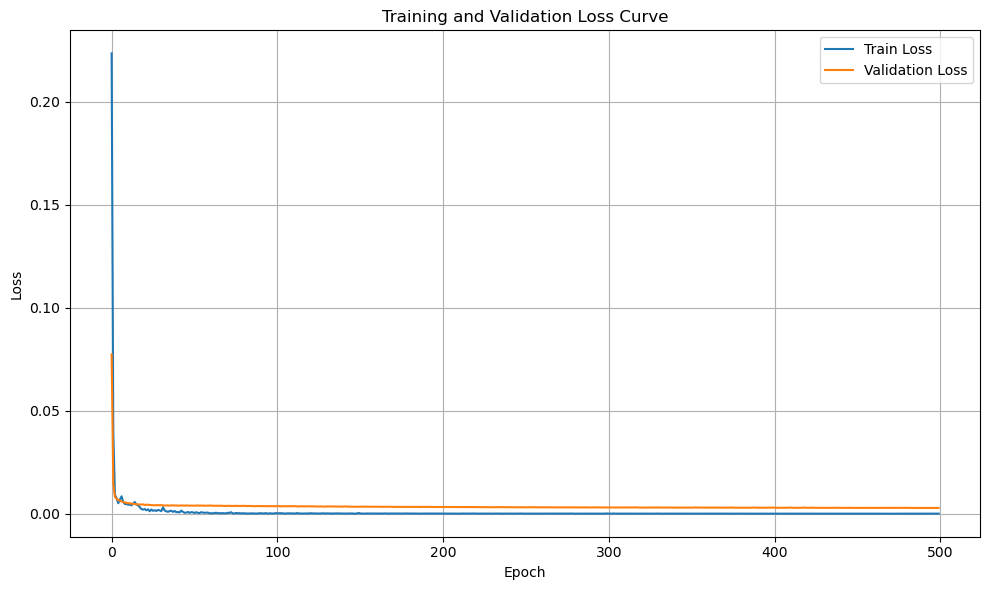

In [26]:
# plot the loss curve
log_path = f'/glade/u/home/joko/ice3d/models/lightning_logs/resnet-18-n1000-default-{target}-csv/version_4/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Drop the 'step' column
metrics_df = metrics_df.drop(columns=['step'])
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
    'val_mae': 'mean'       # Take the mean of the validation accuracy over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')

if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

R2 value for effective density: 0.8373396992683411


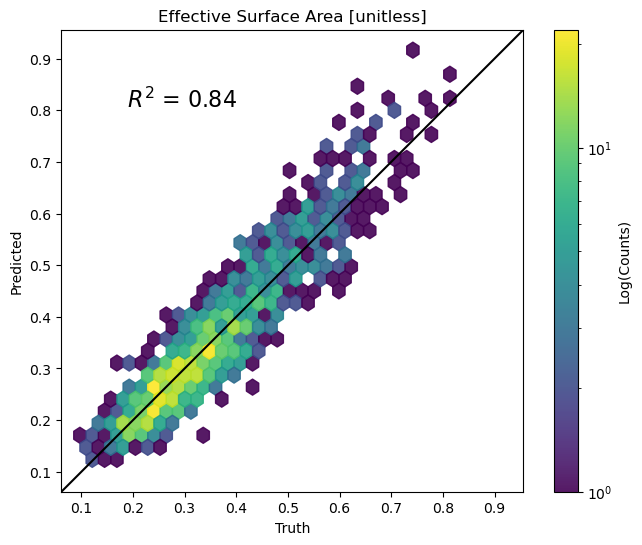

In [27]:
# plot validation scatter plot
# Extract predictions and targets from the model instance
preds = model_rho.val_preds
targets = model_rho.val_targets
# R2 value
r2 = r2_score(preds, targets)
print(f'R2 value for effective density: {r2}')
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
# Create hexbin plot
hb = ax.hexbin(preds, targets, gridsize=30, 
               cmap='viridis', mincnt=1, alpha=0.9, bins='log')
# Add colorbar
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Log(Counts)')
# Plot the identity line (the line where predicted equals truth)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline(xy1=(0, 0), slope=1, color='black')
# Set axis limits and labels
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('Predicted')
ax.set_xlabel('Truth')
ax.set_title('Effective Surface Area [unitless]')
# Add R2 text annotation in relative figure coordinates
ax.text(0.25, 0.75, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
# Show the plot
plt.show()

# Vanilla CNN

## Regression: rho_eff and sa_eff

## Classification: n_arms

# MLP

## a) rho_eff and sa_eff

In [3]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('/glade/u/home/joko/ice3d')
from models.mlp_regression import MLPRegression
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

In [4]:
n_rand = 666 # random seed
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/tabular-data-v2'
data_file = 'ros-tabular-data.parquet'
data_path = os.path.join(data_dir, data_file)

# create train/test set
df = pd.read_parquet(data_path)
df = df[df['view']=='default']
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
targets = ['rho_eff', 'sa_eff']
df = df.sample(70_000) # TEMP: get a subset for efficiency
df.reset_index(inplace=True)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
print(len(X), len(y))

70000 70000


In [5]:
# First: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=n_rand)
# Second: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=n_rand)

In [6]:
y_train.shape

(49000, 2)

In [7]:
from sklearn.preprocessing import StandardScaler
batch_size = 32
num_epochs = 50
learning_rate = 1e-4

# Standardize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert standardized data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
log_y_train_tensor = torch.log(y_train_tensor)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
log_y_val_tensor = torch.log(y_val_tensor)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
log_y_test_tensor = torch.log(y_test_tensor)

input_size = X_train.shape[1]
output_size = y_train.shape[1]

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, log_y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, log_y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, log_y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, and optimizer
model = MLPRegression(input_size, output_size, learning_rate=learning_rate)

# Set up logger information
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'mlp-regression-subset-tb'
csv_log_name = f'mlp-regression-subset-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)

# Set up trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="auto",
    logger=[csv_logger, tb_logger],
    enable_progress_bar=True,
)

# Train the model
trainer.fit(model, train_loader, val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 1.2 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 66     | train
----------------------------------------
11.6 K    Trainable params
0         Non-trainable params
11.6 K    Total params
0.046     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 1532/1532 [00:14<00:00, 103.14it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1532/1532 [00:14<00:00, 103.05it/s, v_num=6]


Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


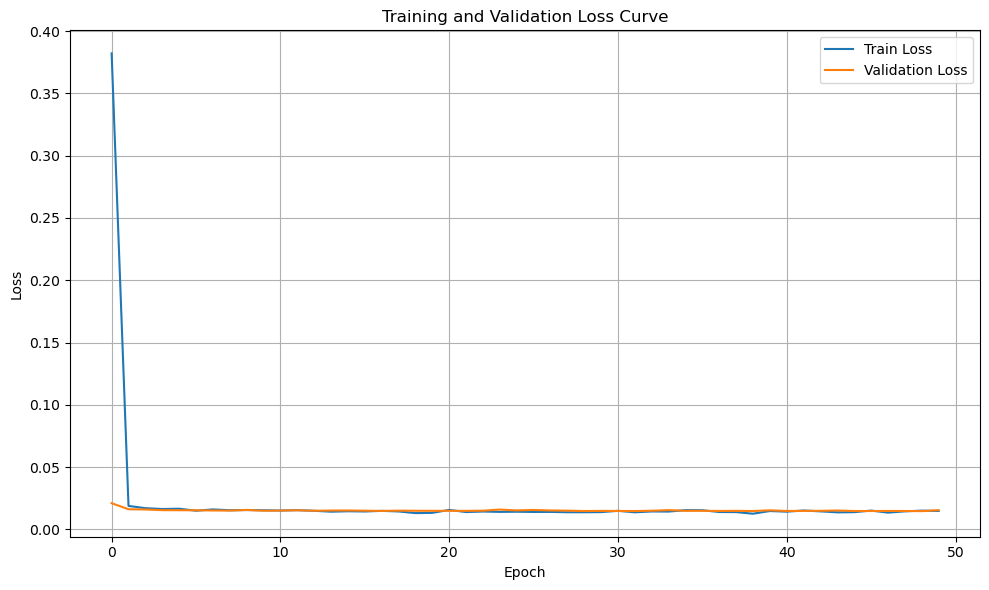

In [8]:
# plot loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/mlp-regression-subset-csv/version_6/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing batch 1 out of 329...
Processing batch 2 out of 329...
Processing batch 3 out of 329...
Processing batch 4 out of 329...
Processing batch 5 out of 329...
Processing batch 6 out of 329...
Processing batch 7 out of 329...
Processing batch 8 out of 329...
Processing batch 9 out of 329...
Processing batch 10 out of 329...
Processing batch 11 out of 329...
Processing batch 12 out of 329...
Processing batch 13 out of 329...
Processing batch 14 out of 329...
Processing batch 15 out of 329...
Processing batch 16 out of 329...
Processing batch 17 out of 329...
Processing batch 18 out of 329...
Processing batch 19 out of 329...
Processing batch 20 out of 329...
Processing batch 21 out of 329...
Processing batch 22 out of 329...
Processing batch 23 out of 329...
Processing batch 24 out of 329...
Processing batch 25 out of 329...
Processing batch 26 out of 329...
Processing batch 27 out of 329...
Processing batch 28 out of 329...
Processing batch 29 out of 329...
Processing batch 30 out

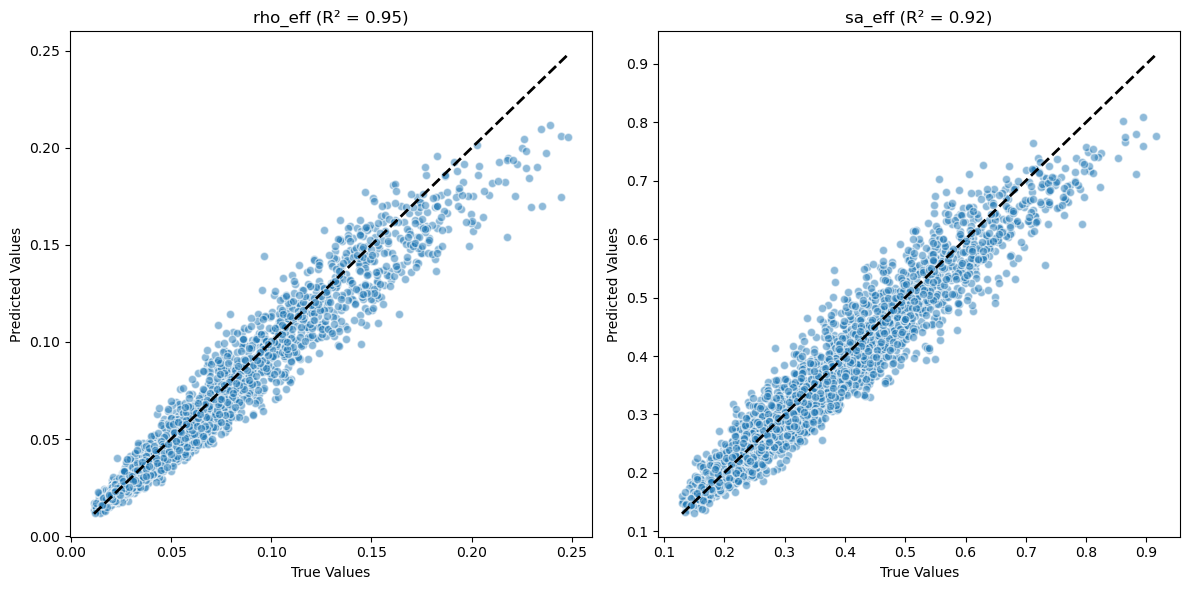

In [9]:
# Set model to evaluation mode
model.eval()

# Convert test data to PyTorch tensors
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
all_preds = []
all_targets = []
n_batches = 100  # Number of batches to process

# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(test_loader)
    for i, batch in enumerate(test_loader):
        if i >= n_batches:  # Stop after 10 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        images, targets = batch
        preds = model(images)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute R² values
r2_rho = r2_score(all_targets[:, 0], all_preds[:, 0])
r2_sa = r2_score(all_targets[:, 1], all_preds[:, 1])
print(f'R² for rho_eff: {r2_rho:.2f}')
print(f'R² for sa_eff: {r2_sa:.2f}')

# Plot scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rho_eff
axes[0].scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.5, edgecolor='white')
axes[0].plot([all_targets[:, 0].min(), all_targets[:, 0].max()],
             [all_targets[:, 0].min(), all_targets[:, 0].max()], 'k--', lw=2)
axes[0].set_title(f'rho_eff (R² = {r2_rho:.2f})')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')

# Scatter plot for sa_eff
axes[1].scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.5, edgecolor='white')
axes[1].plot([all_targets[:, 1].min(), all_targets[:, 1].max()],
             [all_targets[:, 1].min(), all_targets[:, 1].max()], 'k--', lw=2)
axes[1].set_title(f'sa_eff (R² = {r2_sa:.2f})')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [6]:
# # Define the MLP model
# class SimpleMLP(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(SimpleMLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.fc3(x)
#         return x
    
# class ImprovedMLP(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super().__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.bn1 = nn.BatchNorm1d(hidden_size)
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.bn2 = nn.BatchNorm1d(hidden_size)
#         self.relu2 = nn.ReLU()
#         self.dropout2 = nn.Dropout(0.2)
#         self.fc3 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
#         x = self.dropout1(x)
#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
#         x = self.dropout2(x)
#         x = self.fc3(x)
#         return x

# # Grid search parameters
# num_epochs = 200
# batch_size = 128
# learning_rate = 0.001
# hidden_size = 128
# # patience = 10  # Early stopping patience

# # Prepare data
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# log_y_train_tensor = torch.log(y_train_tensor)

# X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
# log_y_val_tensor = torch.log(y_val_tensor)

# input_size = X_train.shape[1]
# output_size = y_train.shape[1]

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

# # Apply log transform to y_train
# # y_train_tensor = torch.log1p(y_train_tensor)
# log_y_train_tensor = torch.log(y_train_tensor)

# # Create DataLoader for batching
# train_dataset = TensorDataset(X_train_tensor, log_y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Model, loss, and optimizer
# input_size = X_train.shape[1]
# output_size = y_train.shape[1]
# model = ImprovedMLP(input_size, hidden_size, output_size)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     epoch_loss = 0.0
#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     if (epoch + 1) % 5 == 0:
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

In [ ]:
# # Grid search 
# # Grid search parameters
# hidden_sizes = [64, 128, 256]
# batch_sizes = [32, 64, 128]
# num_epochs = 100
# patience = 10  # Early stopping patience

# # Prepare data
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# log_y_train_tensor = torch.log(y_train_tensor)

# X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
# log_y_val_tensor = torch.log(y_val_tensor)

# input_size = X_train.shape[1]
# output_size = y_train.shape[1]

# best_val_loss = float('inf')
# best_params = None
# best_model_state = None

# for hidden_size in hidden_sizes:
#     for batch_size in batch_sizes:
#         print(f"\nTraining with hidden_size={hidden_size}, batch_size={batch_size}")
#         model = ImprovedMLP(input_size, hidden_size, output_size)
#         criterion = nn.MSELoss()
#         optimizer = optim.Adam(model.parameters(), lr=0.001)
#         train_dataset = TensorDataset(X_train_tensor, log_y_train_tensor)
#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#         val_dataset = TensorDataset(X_val_tensor, log_y_val_tensor)
#         val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#         best_epoch_val_loss = float('inf')
#         epochs_no_improve = 0

#         for epoch in range(num_epochs):
#             model.train()
#             epoch_loss = 0.0
#             for batch_X, batch_y in train_loader:
#                 optimizer.zero_grad()
#                 outputs = model(batch_X)
#                 loss = criterion(outputs, batch_y)
#                 loss.backward()
#                 optimizer.step()
#                 epoch_loss += loss.item()
#             avg_train_loss = epoch_loss / len(train_loader)

#             # Validation
#             model.eval()
#             val_loss = 0.0
#             with torch.no_grad():
#                 for val_X, val_y in val_loader:
#                     val_outputs = model(val_X)
#                     v_loss = criterion(val_outputs, val_y)
#                     val_loss += v_loss.item()
#             avg_val_loss = val_loss / len(val_loader)

#             if (epoch + 1) % 5 == 0:
#                 print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

#             # Early stopping
#             if avg_val_loss < best_epoch_val_loss:
#                 best_epoch_val_loss = avg_val_loss
#                 epochs_no_improve = 0
#                 best_epoch_model_state = model.state_dict()
#             else:
#                 epochs_no_improve += 1
#                 if epochs_no_improve >= patience:
#                     print(f"Early stopping at epoch {epoch+1}")
#                     break

#         # Save best model for this config
#         if best_epoch_val_loss < best_val_loss:
#             best_val_loss = best_epoch_val_loss
#             best_params = {'hidden_size': hidden_size, 'batch_size': batch_size}
#             best_model_state = best_epoch_model_state

# print(f"\nBest validation loss: {best_val_loss:.4f} with params: {best_params}")

# # To load the best model:
# best_model = ImprovedMLP(input_size, best_params['hidden_size'], output_size)
# best_model.load_state_dict(best_model_state)
# best_model.eval()

In [6]:
# Convert X_val to a PyTorch tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# # Set model to evaluation mode
model.eval()

# Run model on validation data without computing gradients
with torch.no_grad():
    log_y_test_pred = model(X_test_tensor).numpy()
    y_test_pred = np.exp(log_y_test_pred)  # Inverse log transform

In [7]:
# create output dataframe
df_test_out = y_test.rename(columns={'rho_eff':'rho_eff_truth', 'sa_eff':'sa_eff_truth'})
df_test_out['n_arms'] = df['n_arms'].iloc[X_test.index]
df_test_out['filename'] = df['filename'].iloc[X_test.index]
df_test_out['rho_eff_pred'] = y_test_pred[:, 0]
df_test_out['sa_eff_pred'] = y_test_pred[:, 1]

# get score
r2_rho = r2_score(df_test_out['rho_eff_truth'], df_test_out['rho_eff_pred'])
r2_sa = r2_score(df_test_out['sa_eff_truth'], df_test_out['sa_eff_pred'])
print(f'R2 for effective density = {r2_rho}')
print(f'R2 for effective surface area = {r2_sa}')

R2 for effective density = 0.9490031242772871
R2 for effective surface area = 0.91732704032559


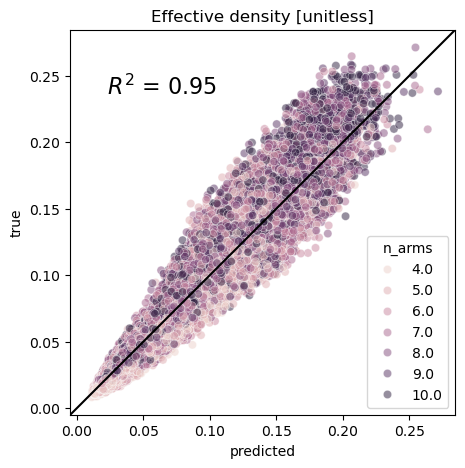

In [8]:
# plot
# df_subset = df_val_out.sample(100_000, random_state=n_rand)
df_subset = df_test_out
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_subset, x='rho_eff_pred', y='rho_eff_truth', 
hue='n_arms', alpha=0.5,
legend='full', edgecolor='white')
# sns.scatterplot(data=df_subset, x='rho_pred', y='rho_truth', 
# size='n_arms', alpha=0.5, palette=mpl.colormaps['plasma'], 
# legend='full')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.7, zorder=0)
ax.axline(xy1=(0,0), slope=1, color='black')
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('true')
ax.set_xlabel('predicted')
ax.set_title('Effective density [unitless]')
ax.text(0.2, 0.75, f'$R^2$ = {r2_rho:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
plt.show()

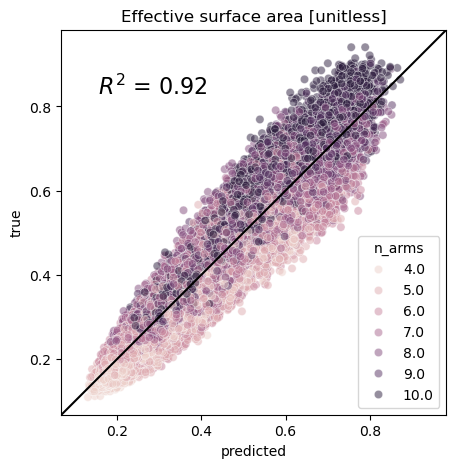

In [11]:
# plot
# df_subset = df_val_out.sample(100_000, random_state=n_rand)
df_subset = df_test_out
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_subset, x='sa_eff_pred', y='sa_eff_truth', 
hue='n_arms', alpha=0.5,
legend='full', edgecolor='white')
# sns.scatterplot(data=df_subset, x='rho_pred', y='rho_truth', 
# size='n_arms', alpha=0.5, palette=mpl.colormaps['plasma'], 
# legend='full')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.7, zorder=0)
ax.axline(xy1=(0,0), slope=1, color='black')
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('true')
ax.set_xlabel('predicted')
ax.set_title('Effective surface area [unitless]')
ax.text(0.2, 0.75, f'$R^2$ = {r2_sa:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
plt.show()

## b) n_arms

In [2]:
import sys
sys.path.append('/glade/u/home/joko/ice3d')
from models.mlp_classification import MLPClassification
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import json
from sklearn.preprocessing import StandardScaler

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

In [3]:
n_rand = 666 # random seed
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/tabular-data-v2'
data_file = 'ros-tabular-data.parquet'
data_path = os.path.join(data_dir, data_file)

# create train/test set
df = pd.read_parquet(data_path)
df = df[df['view']=='default']
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
targets = ['n_arms']
df = df.sample(70_000) # TEMP: get a subset for efficiency
df.reset_index(inplace=True)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
print(len(X), len(y))
# First: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=n_rand)
# Second: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=n_rand)

70000 70000


In [4]:
# set hyperparameters 
batch_size = 32
num_epochs = 50
learning_rate = 1e-4

# Load the class mapping from a JSON file
class_mapping_file = '/glade/u/home/joko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
num_classes = len(class_to_idx)  # Number of unique classes in n_arms

# Standardize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert standardized data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor([class_to_idx[str(v)] for v in y_train['n_arms'].values], dtype=torch.long)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor([class_to_idx[str(v)] for v in y_val['n_arms'].values], dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor([class_to_idx[str(v)] for v in y_test['n_arms'].values], dtype=torch.long)

input_size = X_train.shape[1]

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, and optimizer
model = MLPClassification(input_size, num_classes, learning_rate=learning_rate)

# Set up logger information
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'mlp-classification-subset-tb'
csv_log_name = f'mlp-classification-subset-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)

# Set up trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="auto",
    logger=[csv_logger, tb_logger],
    enable_progress_bar=True,
)

# Train the model
trainer.fit(model, train_loader, val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 1.2 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 231    | train
----------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 1532/1532 [00:15<00:00, 101.94it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1532/1532 [00:15<00:00, 101.86it/s, v_num=2]


Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


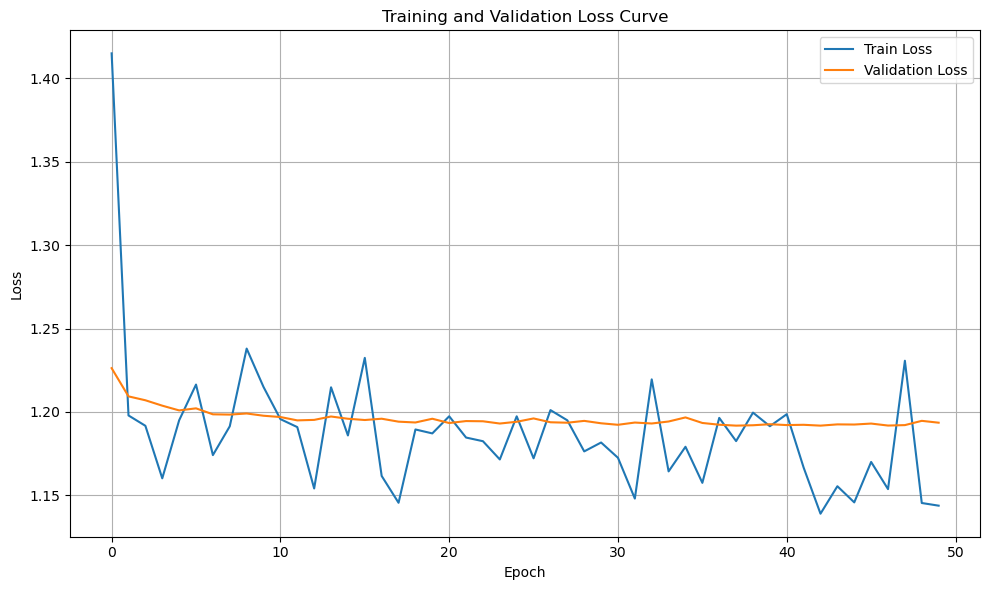

In [5]:
# plot loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/mlp-classification-subset-csv/version_2/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

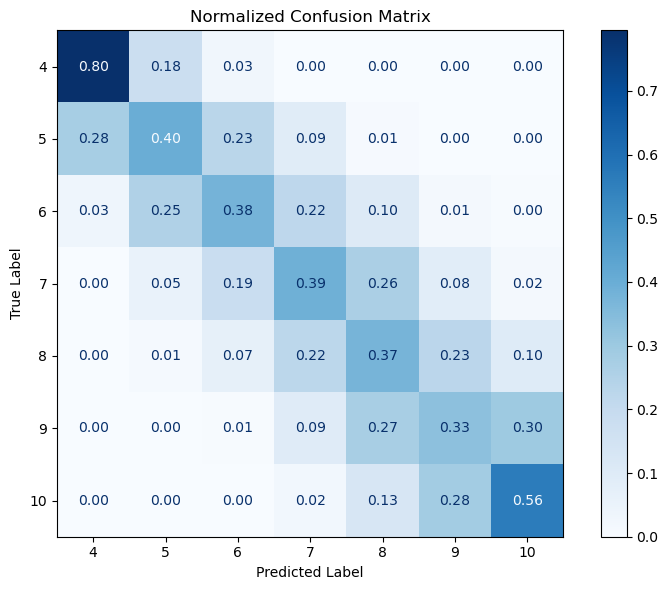

In [6]:
# Set model to evaluation mode
model.eval()

# Convert test data to PyTorch tensors
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
all_preds = []
all_targets = []

# Run inference on the test data
with torch.no_grad():
    for batch in test_loader:
        images, targets = batch
        preds = model(images)
        preds = torch.argmax(preds, dim=1)  # Get the predicted class
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Map predictions and targets back to original labels
idx_to_class = {v: int(float(k)) for k, v in class_to_idx.items()}  # Reverse the class mapping robustly
all_preds_mapped = [idx_to_class[p] for p in all_preds]
all_targets_mapped = [idx_to_class[t] for t in all_targets]

# Compute confusion matrix
cm = confusion_matrix(all_targets_mapped, all_preds_mapped, normalize='true')

# Plot the confusion matrix
class_labels = list(idx_to_class.values())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [20]:
# Define the MLP model for classification
class SimpleMLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Update the ImprovedMLP class for classification
class ImprovedMLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# set hyperparameters 
batch_size = 64
num_epochs = 100
learning_rate = 0.001
hidden_size = 128

# Prepare data for classification
num_classes = len(y_train['n_arms'].unique())  # Number of unique classes in n_arms
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# Map n_arms labels from [4,5,6,7,8,9,10] to [0,1,2,3,4,5,6]
label_map = {v: i for i, v in enumerate(sorted(y_train['n_arms'].unique()))}
y_train_tensor = torch.tensor([label_map[v] for v in y_train['n_arms'].values], dtype=torch.long)
y_val_tensor = torch.tensor([label_map[v] for v in y_val['n_arms'].values], dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, loss, and optimizer
model = ImprovedMLPClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()  # Classification loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 5/100, Loss: 1.2919
Epoch 10/100, Loss: 1.2735
Epoch 15/100, Loss: 1.2698
Epoch 20/100, Loss: 1.2651
Epoch 25/100, Loss: 1.2659
Epoch 30/100, Loss: 1.2610
Epoch 35/100, Loss: 1.2591
Epoch 40/100, Loss: 1.2652
Epoch 45/100, Loss: 1.2557
Epoch 50/100, Loss: 1.2590
Epoch 55/100, Loss: 1.2549
Epoch 60/100, Loss: 1.2546
Epoch 65/100, Loss: 1.2545
Epoch 70/100, Loss: 1.2577
Epoch 75/100, Loss: 1.2529
Epoch 80/100, Loss: 1.2517
Epoch 85/100, Loss: 1.2516
Epoch 90/100, Loss: 1.2495
Epoch 95/100, Loss: 1.2510
Epoch 100/100, Loss: 1.2528


In [21]:
# predict on test set
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# Set model to evaluation mode
model.eval()    
# Run model on validation data without computing gradients
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    _, preds = torch.max(y_test_pred, 1)

# After prediction
inv_label_map = {v: k for k, v in label_map.items()}
pred_labels = [inv_label_map[int(i)] for i in preds]

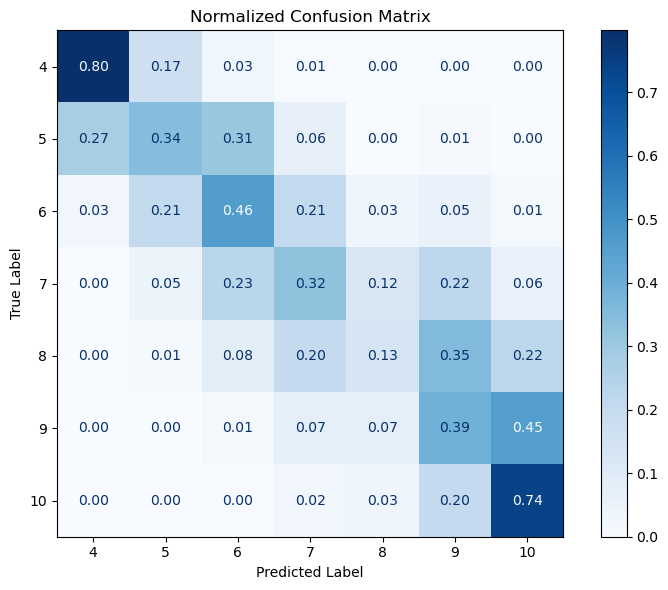

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# Extract predictions and targets
preds = pred_labels
targets = y_test.values.ravel()

# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')

# Plot the confusion matrix
class_labels = ['4', '5', '6', '7', '8', '9', '10']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Test python module imports

In [11]:
import sys
sys.path.append('/glade/u/home/joko/ice3d')
from data.single_view_dataset import SingleViewDataset
from data.single_view_datamodule import SingleViewDataModule

Dataset length: 1000
Image tensor shape: torch.Size([3, 224, 224]), dtype: torch.float32
Target: tensor([10.]), dtype: torch.float32


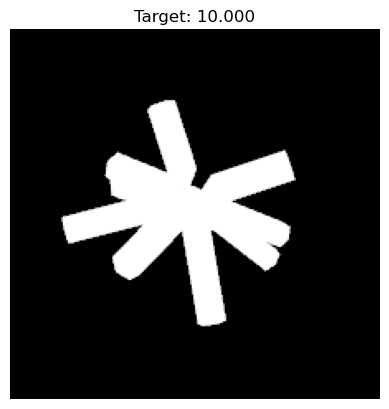

In [13]:
# Path to your HDF5 file and the target dataset name
hdf_path = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/default.h5'
target_name = 'n_arms'  # or 'sa_eff', 'n_arms', etc.
indices = list(range(1_000))

# Instantiate the dataset
dataset = SingleViewDataset(hdf_path, target_name, indices)

# Print dataset length
print(f"Dataset length: {len(dataset)}")

# Get a random sample
random_idx = random.randint(0, len(dataset) - 1)
img_tensor, target = dataset[random_idx]
print(f"Image tensor shape: {img_tensor.shape}, dtype: {img_tensor.dtype}")
print(f"Target: {target}, dtype: {target.dtype}")

# Visualize the image (convert from (3, H, W) to (H, W, 3))
img_np = img_tensor.permute(1, 2, 0).numpy().astype(np.uint8)
plt.imshow(img_np)
plt.title(f"Target: {target.item():.3f}")
plt.axis('off')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

# Set your parameters
hdf_file = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/default.h5'
batch_size = 64
target = 'n_arms'  # Replace with your actual target column name
random_state = 666
# specify train/val/test indices using sklearn
indices = np.arange(7_000_000)
# indices = list(range(7_000_000))
train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=random_state)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=random_state)
# sort all idx numpy arrays
train_idx.sort()
val_idx.sort()
test_idx.sort()
subset_size = 0.001  # subset percentage

In [ ]:
# from sklearn.model_selection import train_test_split

# # Set your parameters
# hdf_file = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/default.h5'
# batch_size = 64
# target = 'n_arms'  # Replace with your actual target column name
# random_state = 666
# # specify train/val/test indices using sklearn
# indices = np.arange(7_000_000)
# train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=random_state)
# val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=random_state)
# subset_size = 0.001  # subset percentage

# Instantiate the DataModule
print('checkpoint 1')
dm = SingleViewDataModule(hdf_file, target, train_idx, val_idx, test_idx, batch_size, subset_size=0.01, subset_seed=random_state)

# Setup the datasets
print('checkpoint 2')
dm.setup()

# Get a batch from the train dataloader
print('checkpoint 3')
train_loader = dm.train_dataloader()
batch = next(iter(train_loader))

print(f"Batch type: {type(batch)}")
if isinstance(batch, (tuple, list)):
    print(f"Batch[0] shape: {batch[0].shape}")
else:
    print(f"Batch shape: {batch.shape}")

# Visualize all the images in the batch as a grid
import matplotlib.pyplot as plt

if isinstance(batch, (tuple, list)):
    images = batch[0]
else:
    images = batch

if isinstance(images, torch.Tensor) and images.ndim == 4:  # Ensure it's a batch of images
    batch_size = images.shape[0]
    grid_size = int(np.ceil(np.sqrt(batch_size)))  # Determine grid size
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten()
    
    for i in range(batch_size):
        img = images[i]
        if img.ndim == 3:  # Ensure it's a single image tensor
            axes[i].imshow(img.permute(1, 2, 0).numpy().astype('uint8'))
            axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(batch_size, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

checkpoint 1
checkpoint 2
Subsetting 4900000 indices with seed 666
Subsetting to 49000 indices
finished random choice
finished sorting
Time to subset train indices: 0.0043 seconds
Subsetting 1050000 indices with seed 666
Subsetting to 10500 indices
finished random choice
finished sorting
Time to subset val indices: 0.0007 seconds
Subsetting 1050000 indices with seed 666
Subsetting to 10500 indices
finished random choice
finished sorting
Time to subset test indices: 0.0005 seconds


In [19]:
# what is the length of train/val/test datasets?
print(f"Train dataset length: {len(dm.train_dataset)}")
print(f"Validation dataset length: {len(dm.val_dataset)}")
print(f"Test dataset length: {len(dm.test_dataset)}")

Train dataset length: 49000
Validation dataset length: 10500
Test dataset length: 10500


Batch type: <class 'list'>
Batch[0] shape: torch.Size([64, 3, 224, 224])


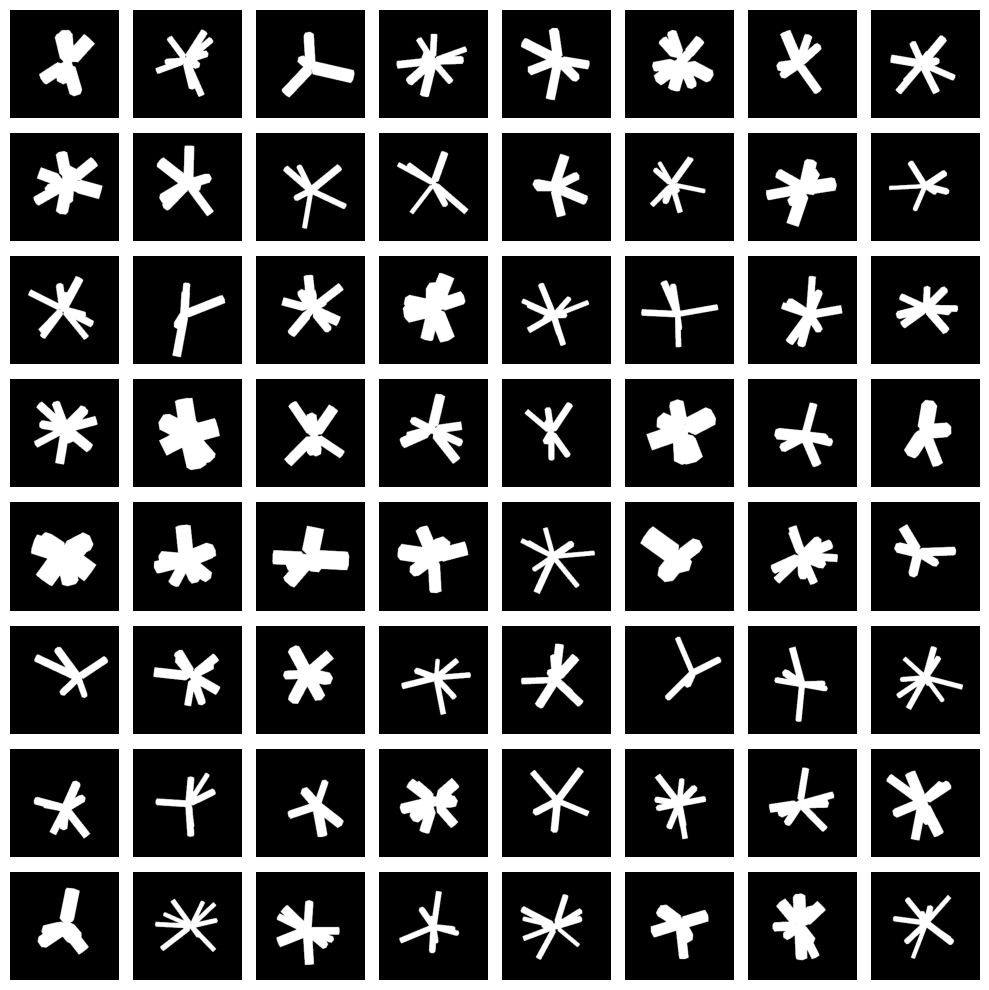

In [22]:
batch = next(iter(train_loader))

print(f"Batch type: {type(batch)}")
if isinstance(batch, (tuple, list)):
    print(f"Batch[0] shape: {batch[0].shape}")
else:
    print(f"Batch shape: {batch.shape}")

# Visualize all the images in the batch as a grid
import matplotlib.pyplot as plt

if isinstance(batch, (tuple, list)):
    images = batch[0]
else:
    images = batch

if isinstance(images, torch.Tensor) and images.ndim == 4:  # Ensure it's a batch of images
    batch_size = images.shape[0]
    grid_size = int(np.ceil(np.sqrt(batch_size)))  # Determine grid size
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten()
    
    for i in range(batch_size):
        img = images[i]
        if img.ndim == 3:  # Ensure it's a single image tensor
            axes[i].imshow(img.permute(1, 2, 0).numpy().astype('uint8'))
            axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(batch_size, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Training with h5 files

## Single view

### CNN (regression)

In [2]:
import sys
sys.path.append('/glade/u/home/joko/ice3d')
from data.single_view_dataset import SingleViewDataset
from data.single_view_datamodule import SingleViewDataModule
from models.cnn_regression import VanillaCNNRegression
from sklearn.model_selection import train_test_split
import torchvision.transforms as T

In [3]:
%%time
# Set up dataset and dataloader

# Set your parameters
hdf_file = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/default.h5'
batch_size = 128
targets = ['rho_eff', 'sa_eff']  # Replace with your actual target column name
random_state = 666
lr = 1e-3
n_epochs = 30
# num_gpus = torch.cuda.device_count()
num_gpus = 1

# specify train/val/test indices using sklearn
indices = list(range(7_000_000))
train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=random_state)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=random_state)
subset_size = 0.05  # subset percentage

# set up logger information
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'cnn-vanilla-regression-subset-tb'
csv_log_name = f'cnn-vanilla-regression-subset-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)

# Input transform: random crop, flip, normalization, etc.
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0, 1.0]),
])

# validation transform: resize, normalization
val_transform = T.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0, 1.0])
])

# Output transform: log-transform
def log_transform(target):
    # return torch.log1p(target)  # log(1 + x) for numerical stability
    return torch.log(target)  # log(x) for positive values

# Instantiate the DataModule
print('instantiate datamodule...')
dm = SingleViewDataModule(
    hdf_file=hdf_file,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=18,
    prefetch_factor=4,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=log_transform,
    val_target_transform=log_transform,
    test_target_transform=log_transform
)

# train VanillaCNNRegression
print('set up model and trainer...')
model = VanillaCNNRegression(input_channels=3, output_size=len(targets), learning_rate=lr)
trainer = Trainer(max_epochs=n_epochs, 
                  accelerator="auto",
                  devices=num_gpus,
                  strategy="ddp_notebook", # distributed data parallel
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=True)

# train model
print(f'Training model with {num_gpus} gpu(s)...')
trainer.fit(model, dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


instantiate datamodule...
set up model and trainer...
Training model with 1 gpu(s)...


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torch/distributed/algorithms/ddp_comm_hooks/__init__.py:54: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 0:   2%|▏         | 36/1914 [00:05<05:00,  6.25it/s, v_num=16]       

Epoch 29: 100%|██████████| 1914/1914 [00:53<00:00, 35.78it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1914/1914 [00:53<00:00, 35.60it/s, v_num=16]
CPU times: user 42.4 s, sys: 26.2 s, total: 1min 8s
Wall time: 31min 9s


Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


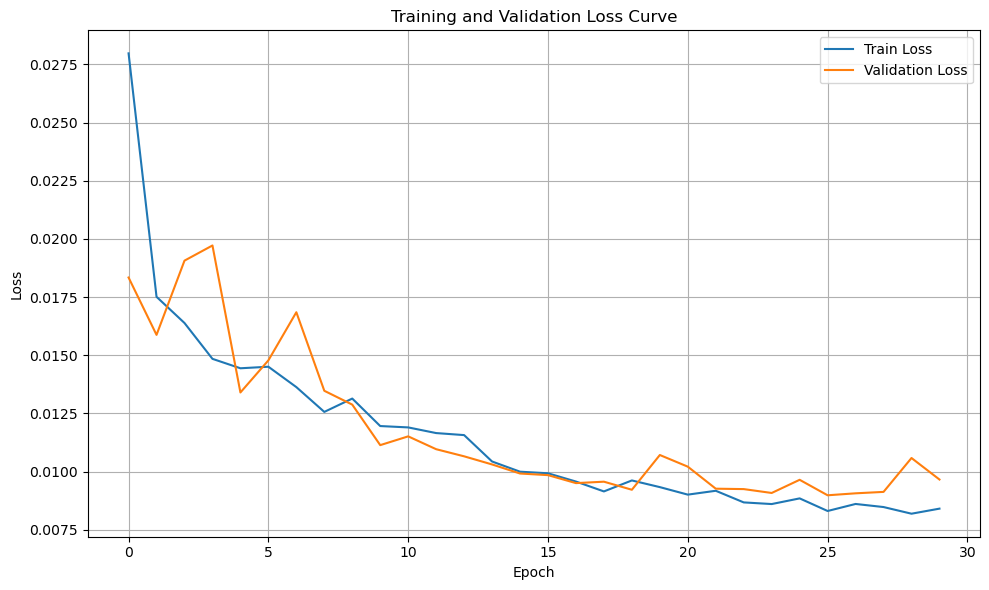

In [4]:
# plot the loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/cnn-vanilla-regression-subset-csv/version_16/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
dm = SingleViewDataModule(
    hdf_file=hdf_file,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=18,
    prefetch_factor=4,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=log_transform,
    val_target_transform=log_transform,
    test_target_transform=log_transform
)

In [6]:
dm.setup()

In [7]:
# Print the number of samples in train, validation, and test datasets
print(f"Number of samples in train dataset: {len(dm.train_dataset)}")
print(f"Number of samples in validation dataset: {len(dm.val_dataset)}")
print(f"Number of samples in test dataset: {len(dm.test_dataset)}")

Number of samples in train dataset: 245000
Number of samples in validation dataset: 52500
Number of samples in test dataset: 52500


Processing batch 1 out of 411...
Processing batch 2 out of 411...
Processing batch 3 out of 411...
Processing batch 4 out of 411...
Processing batch 5 out of 411...
Processing batch 6 out of 411...
Processing batch 7 out of 411...
Processing batch 8 out of 411...
Processing batch 9 out of 411...
Processing batch 10 out of 411...
Processing batch 11 out of 411...
Processing batch 12 out of 411...
Processing batch 13 out of 411...
Processing batch 14 out of 411...
Processing batch 15 out of 411...
Processing batch 16 out of 411...
Processing batch 17 out of 411...
Processing batch 18 out of 411...
Processing batch 19 out of 411...
Processing batch 20 out of 411...
R² for rho_eff: 0.95
R² for sa_eff: 0.93


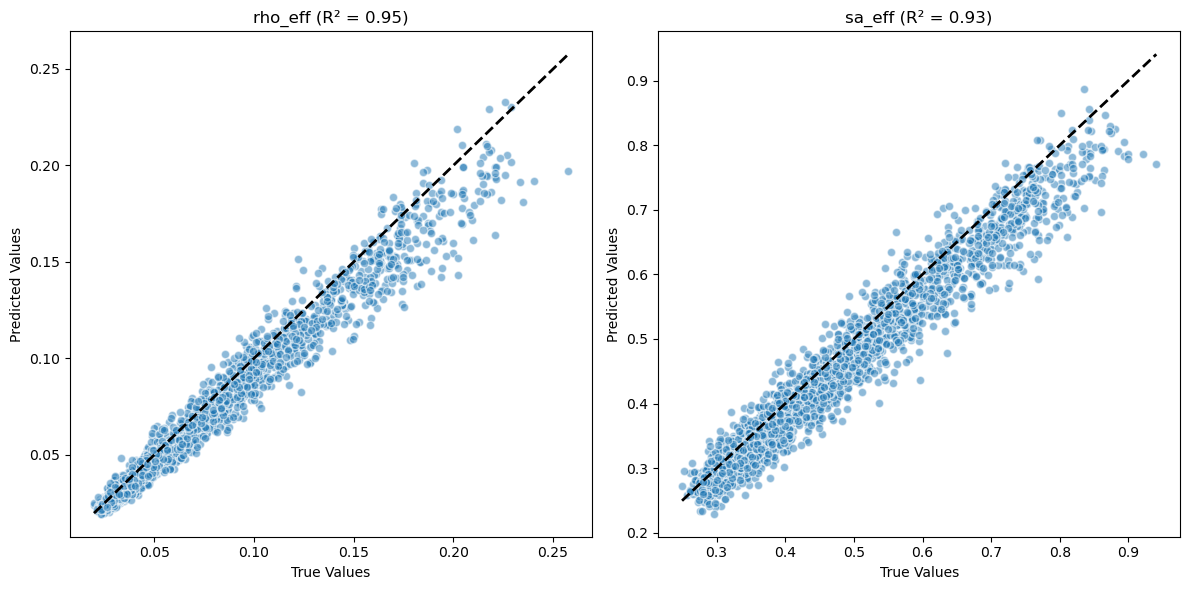

In [8]:
# Set model to evaluation mode
model.eval()

# Convert test data to PyTorch tensors
test_loader = dm.test_dataloader()
all_preds = []
all_targets = []
n_batches = 20  # Number of batches to process

# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(test_loader)
    for i, batch in enumerate(test_loader):
        if i >= n_batches:  # Stop after 20 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        images, targets = batch
        preds = model(images)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute R² values
r2_rho = r2_score(all_targets[:, 0], all_preds[:, 0])
r2_sa = r2_score(all_targets[:, 1], all_preds[:, 1])
print(f'R² for rho_eff: {r2_rho:.2f}')
print(f'R² for sa_eff: {r2_sa:.2f}')

# Plot scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rho_eff
axes[0].scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.5, edgecolor='white')
axes[0].plot([all_targets[:, 0].min(), all_targets[:, 0].max()],
             [all_targets[:, 0].min(), all_targets[:, 0].max()], 'k--', lw=2)
axes[0].set_title(f'rho_eff (R² = {r2_rho:.2f})')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')

# Scatter plot for sa_eff
axes[1].scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.5, edgecolor='white')
axes[1].plot([all_targets[:, 1].min(), all_targets[:, 1].max()],
             [all_targets[:, 1].min(), all_targets[:, 1].max()], 'k--', lw=2)
axes[1].set_title(f'sa_eff (R² = {r2_sa:.2f})')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

### Resnet (regression)

In [2]:
import sys
sys.path.append('/glade/u/home/joko/ice3d')
from data.single_view_dataset import SingleViewDataset
from data.single_view_datamodule import SingleViewDataModule
from models.resnet18_regression import ResNet18Regression
import json

In [3]:
%%time
# Set up dataset and dataloader

# Set your parameters
hdf_file = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/default.h5'
batch_size = 128
targets = ['rho_eff', 'sa_eff']  # Replace with your actual target column name
random_state = 666
lr = 1e-3
n_epochs = 10
# num_gpus = torch.cuda.device_count()
num_gpus = 1
num_cpus = 18

# specify train/val/test indices using sklearn
indices = list(range(7_000_000))
train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=random_state)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=random_state)
subset_size = 0.01  # subset percentage

# set up logger information
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'resnet18-regression-subset-tb'
csv_log_name = f'resnet18-regression-subset-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)

# Input transform: random crop, flip, normalization, etc.
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5],       # Zero-mean normalization
                         std=[1.0]),
])

# validation transform: resize, normalization
val_transform = T.Compose([
    transforms.Normalize(mean=[0.5],       # Zero-mean normalization
                         std=[1.0])
])

# Output transform: log-transform
def log_transform(target):
    # return torch.log1p(target)  # log(1 + x) for numerical stability
    return torch.log(target)  # log(x) for positive values

# Instantiate the DataModule
print('instantiate datamodule...')
dm = SingleViewDataModule(
    hdf_file=hdf_file,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=num_cpus,
    prefetch_factor=16,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=log_transform,
    val_target_transform=log_transform,
    test_target_transform=log_transform
)

# train model
print('set up model and trainer...')
model = ResNet18Regression(input_channels=1, output_size=len(targets), learning_rate=lr)
trainer = Trainer(max_epochs=n_epochs, 
                  accelerator="auto",
                  devices=num_gpus,
                  strategy="ddp_notebook", # distributed data parallel
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=True)

# train model
print(f'Training model with {num_gpus} gpu(s)...')
trainer.fit(model, dm)

instantiate datamodule...
set up model and trainer...


/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model with 1 gpu(s)...


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torch/distributed/algorithms/ddp_comm_hooks/__init__.py:54: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  ALLREDUCE = partial(_ddp_comm_hook_wrapper, comm_hook=default.allreduce_hook)
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torch/distributed/algorithms/ddp_comm_hooks/__init__.py:55: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want t

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 9: 100%|██████████| 382/382 [00:43<00:00,  8.74it/s, v_num=8]it/s]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 382/382 [00:47<00:00,  8.02it/s, v_num=8]
CPU times: user 7 s, sys: 2.43 s, total: 9.43 s
Wall time: 7min 57s


In [4]:
dm = SingleViewDataModule(
    hdf_file=hdf_file,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=num_cpus,
    prefetch_factor=4,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=log_transform,
    val_target_transform=log_transform,
    test_target_transform=log_transform
)
dm.setup()

Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


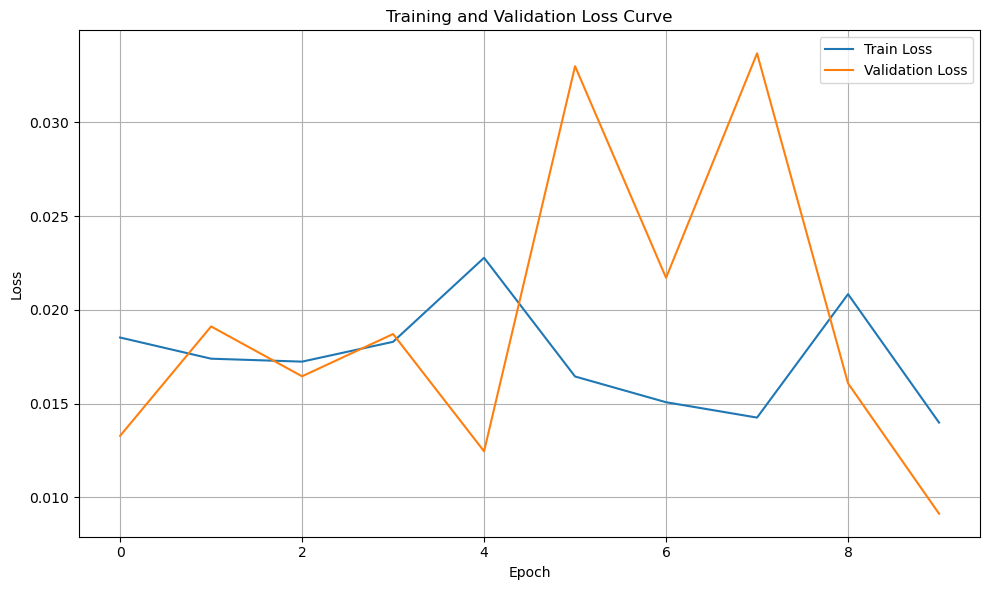

In [5]:
# plot the loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/resnet18-regression-subset-csv/version_8/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing batch 1 out of 83...
Processing batch 2 out of 83...
Processing batch 3 out of 83...
Processing batch 4 out of 83...
Processing batch 5 out of 83...
Processing batch 6 out of 83...
Processing batch 7 out of 83...
Processing batch 8 out of 83...
Processing batch 9 out of 83...
Processing batch 10 out of 83...
R² for rho_eff: 0.96
R² for sa_eff: 0.95


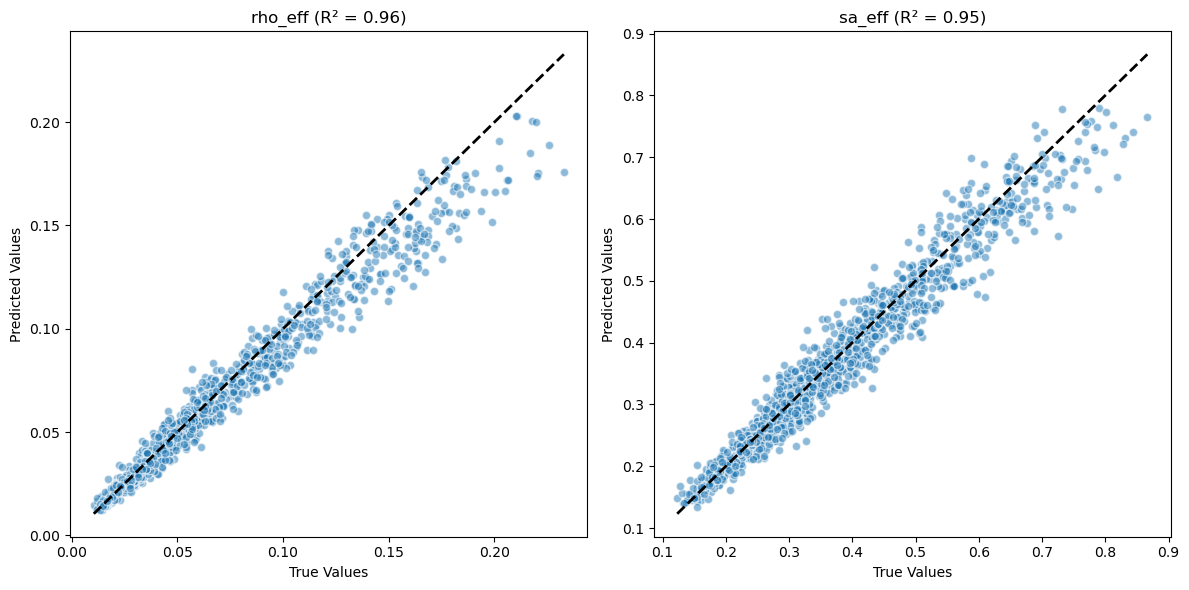

In [6]:
# Set model to evaluation mode
model.eval()

# Convert test data to PyTorch tensors
# test_loader = dm.test_dataloader()
test_loader = torch.utils.data.DataLoader(dm.test_dataset, batch_size=128, shuffle=True)
all_preds = []
all_targets = []
n_batches = 10  # Number of batches to process

# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(test_loader)
    for i, batch in enumerate(test_loader):
        if i >= n_batches:  # Stop after 20 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        images, targets = batch
        preds = model(images)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute R² values
r2_rho = r2_score(all_targets[:, 0], all_preds[:, 0])
r2_sa = r2_score(all_targets[:, 1], all_preds[:, 1])
print(f'R² for rho_eff: {r2_rho:.2f}')
print(f'R² for sa_eff: {r2_sa:.2f}')

# Plot scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rho_eff
axes[0].scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.5, edgecolor='white')
axes[0].plot([all_targets[:, 0].min(), all_targets[:, 0].max()],
             [all_targets[:, 0].min(), all_targets[:, 0].max()], 'k--', lw=2)
axes[0].set_title(f'rho_eff (R² = {r2_rho:.2f})')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')

# Scatter plot for sa_eff
axes[1].scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.5, edgecolor='white')
axes[1].plot([all_targets[:, 1].min(), all_targets[:, 1].max()],
             [all_targets[:, 1].min(), all_targets[:, 1].max()], 'k--', lw=2)
axes[1].set_title(f'sa_eff (R² = {r2_sa:.2f})')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

### CNN (classification)

In [2]:
import sys
sys.path.append('/glade/u/home/joko/ice3d')
from data.single_view_dataset import SingleViewDataset
from data.single_view_datamodule import SingleViewDataModule
from models.cnn_classification import VanillaCNNClassification
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import json

In [3]:
%%time
# Set up dataset and dataloader

# Set your parameters
hdf_file = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/default.h5'
batch_size = 128
targets = ['n_arms']  # Replace with your actual target column name
random_state = 666
lr = 1e-3
n_epochs = 10
# num_gpus = torch.cuda.device_count()
num_gpus = 1
num_cpus = 18

# specify train/val/test indices using sklearn
indices = list(range(7_000_000))
train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=random_state)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=random_state)
subset_size = 0.01  # subset percentage

# set up logger information
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'cnn-vanilla-classification-subset-tb'
csv_log_name = f'cnn-vanilla-classification-subset-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)

# Input transform: random crop, flip, normalization, etc.
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0, 1.0]),
])

# validation transform: resize, normalization
val_transform = T.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0, 1.0])
])

class_mapping_file = '/glade/u/home/joko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
num_classes = len(class_to_idx)  # Number of unique classes in n_arms

# Instantiate the DataModule
print('instantiate datamodule...')
dm = SingleViewDataModule(
    hdf_file=hdf_file,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=num_cpus,
    prefetch_factor=4,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=None,
    val_target_transform=None,
    test_target_transform=None,
    task_type='classification',  # Specify the task type
    class_to_idx=class_to_idx  # Optional: mapping of class names to indices
)

# train VanillaCNNClassification
print('set up model and trainer...')
model = VanillaCNNClassification(input_channels=3, num_classes=num_classes, learning_rate=lr)
trainer = Trainer(max_epochs=n_epochs, 
                  accelerator="auto",
                  devices=num_gpus,
                  strategy="ddp_notebook", # distributed data parallel
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=True)

# train model
print(f'Training model with {num_gpus} gpu(s)...')
trainer.fit(model, dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


instantiate datamodule...
set up model and trainer...
Training model with 1 gpu(s)...


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torch/distributed/algorithms/ddp_comm_hooks/__init__.py:54: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 9: 100%|██████████| 382/382 [00:09<00:00, 38.63it/s, v_num=4]        

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 382/382 [00:10<00:00, 38.02it/s, v_num=4]
CPU times: user 5.35 s, sys: 1.82 s, total: 7.17 s
Wall time: 1min 53s


Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


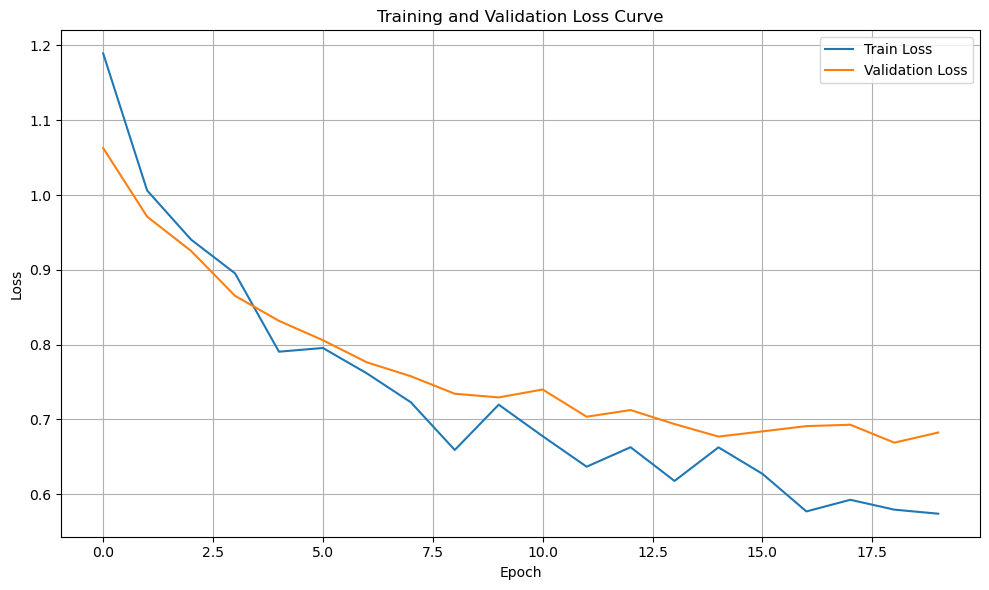

In [ ]:
# plot the loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/cnn-vanilla-classification-subset-csv/version_4/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)         
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# load dm again
dm = SingleViewDataModule(
    hdf_file=hdf_file,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=18,
    prefetch_factor=4,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=None,
    val_target_transform=None,
    test_target_transform=None,
    task_type='classification',  # Specify the task type
    class_to_idx=class_to_idx  # Optional: mapping of class names to indices
)
dm.setup()

In [ ]:
# # Print unique classes in train, validation, and test datasets
# import numpy as np

# def get_unique_targets(dataset):
#     targets = []
#     for i in range(len(dataset)):
#         _, target = dataset[i]
#         targets.append(int(target) if hasattr(target, 'item') else target)
#     return np.unique(targets)

# print(f"Unique classes in train dataset: {get_unique_targets(dm.train_dataset)}")
# print(f"Unique classes in validation dataset: {get_unique_targets(dm.val_dataset)}")
# print(f"Unique classes in test dataset: {get_unique_targets(dm.test_dataset)}")

Unique classes in train dataset: [0 1 2 3 4 5 6]
Unique classes in validation dataset: [0 1 2 3 4 5 6]
Unique classes in test dataset: [0 1 2 3 4 5 6]


Processing batch 1 out of 411...
Processing batch 2 out of 411...
Processing batch 3 out of 411...
Processing batch 4 out of 411...
Processing batch 5 out of 411...
Processing batch 6 out of 411...
Processing batch 7 out of 411...
Processing batch 8 out of 411...
Processing batch 9 out of 411...
Processing batch 10 out of 411...
Processing batch 11 out of 411...
Processing batch 12 out of 411...
Processing batch 13 out of 411...
Processing batch 14 out of 411...
Processing batch 15 out of 411...
Processing batch 16 out of 411...
Processing batch 17 out of 411...
Processing batch 18 out of 411...
Processing batch 19 out of 411...
Processing batch 20 out of 411...
Accuracy: 0.71


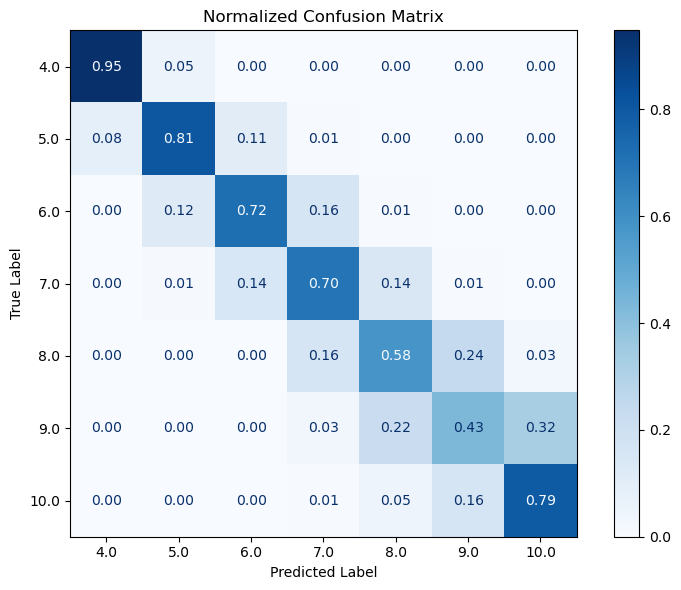

In [6]:
# set model to evaluation mode
model.eval()
# run inference on test set
# test_loader = dm.test_dataloader()
test_loader = torch.utils.data.DataLoader(dm.test_dataset, batch_size=128, shuffle=True)
all_preds = []
all_targets = []
n_batches = 20  # Number of batches to process
# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(test_loader)
    for i, batch in enumerate(test_loader):
        if i >= n_batches:  # Stop after 20 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        images, targets = batch
        preds = model(images)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Convert model outputs to predicted class indices
pred_labels = np.argmax(all_preds, axis=1)

# Compute accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_targets, pred_labels)
print(f'Accuracy: {accuracy:.2f}')

# Compute confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(all_targets, pred_labels, normalize='true')
class_labels = list(class_to_idx.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Resnet (classification)

In [2]:
import sys
sys.path.append('/glade/u/home/joko/ice3d')
from data.single_view_dataset import SingleViewDataset
from data.single_view_datamodule import SingleViewDataModule
from models.resnet18_classification import ResNet18Classification
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import json

In [3]:
%%time
# Set up dataset and dataloader

# Set your parameters
hdf_file = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/default.h5'
batch_size = 128
targets = ['n_arms']  # Replace with your actual target column name
random_state = 666
lr = 1e-3
n_epochs = 30
# num_gpus = torch.cuda.device_count()
num_gpus = 1
num_cpus = 18

# specify train/val/test indices using sklearn
indices = list(range(7_000_000))
train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=random_state)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=random_state)
subset_size = 0.05  # subset percentage

# set up logger information
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'resnet18-classification-subset-tb'
csv_log_name = f'resnet18-classification-subset-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)

# Input transform: random crop, flip, normalization, etc.
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0, 1.0]),
])

# validation transform: resize, normalization
val_transform = T.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0, 1.0])
])

class_mapping_file = '/glade/u/home/joko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
num_classes = len(class_to_idx)  # Number of unique classes in n_arms

# Instantiate the DataModule
print('instantiate datamodule...')
dm = SingleViewDataModule(
    hdf_file=hdf_file,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=num_cpus,
    prefetch_factor=4,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=None,
    val_target_transform=None,
    test_target_transform=None,
    task_type='classification',  # Specify the task type
    class_to_idx=class_to_idx  # Optional: mapping of class names to indices
)

# train VanillaCNNClassification
print('set up model and trainer...')
model = ResNet18Classification(input_channels=3, num_classes=num_classes, learning_rate=lr)
trainer = Trainer(max_epochs=n_epochs, 
                  accelerator="auto",
                  devices=num_gpus,
                  strategy="ddp_notebook", # distributed data parallel
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=True)

# train model
print(f'Training model with {num_gpus} gpu(s)...')
trainer.fit(model, dm)

instantiate datamodule...
set up model and trainer...


/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model with 1 gpu(s)...


You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torch/distributed/algorithms/ddp_comm_hooks/__init__.py:54: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 29: 100%|██████████| 1914/1914 [01:10<00:00, 27.15it/s, v_num=2]     

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1914/1914 [01:10<00:00, 26.99it/s, v_num=2]
CPU times: user 36.8 s, sys: 17.6 s, total: 54.3 s
Wall time: 35min 6s


Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


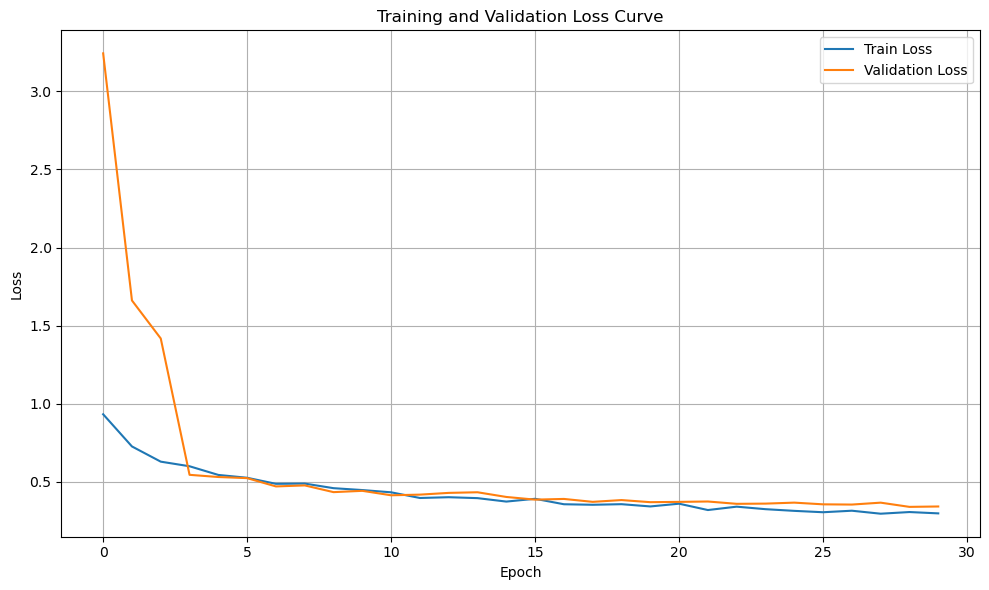

In [4]:
# plot the loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/resnet18-classification-subset-csv/version_2/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)         
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing batch 1 out of 411...
Processing batch 2 out of 411...
Processing batch 3 out of 411...
Processing batch 4 out of 411...
Processing batch 5 out of 411...
Processing batch 6 out of 411...
Processing batch 7 out of 411...
Processing batch 8 out of 411...
Processing batch 9 out of 411...
Processing batch 10 out of 411...
Processing batch 11 out of 411...
Processing batch 12 out of 411...
Processing batch 13 out of 411...
Processing batch 14 out of 411...
Processing batch 15 out of 411...
Processing batch 16 out of 411...
Processing batch 17 out of 411...
Processing batch 18 out of 411...
Processing batch 19 out of 411...
Processing batch 20 out of 411...
Accuracy: 0.87


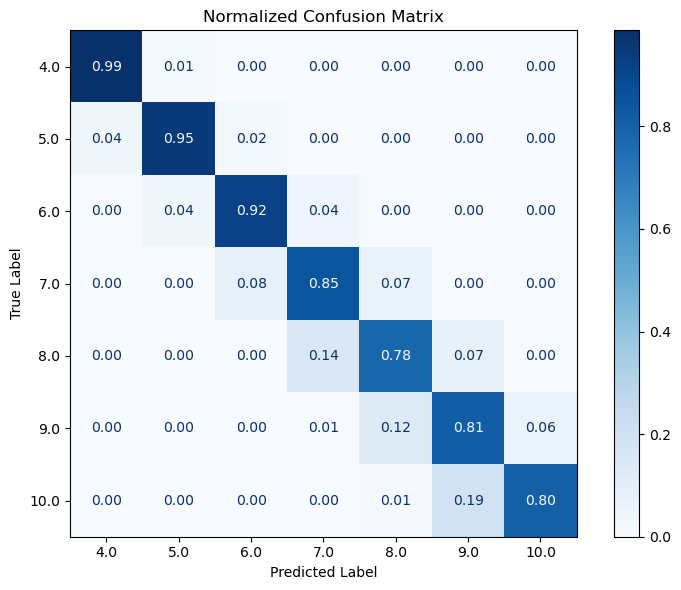

In [5]:
# load dm again
dm = SingleViewDataModule(
    hdf_file=hdf_file,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=18,
    prefetch_factor=4,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=None,
    val_target_transform=None,
    test_target_transform=None,
    task_type='classification',  # Specify the task type
    class_to_idx=class_to_idx  # Optional: mapping of class names to indices
)
dm.setup()

# set model to evaluation mode
model.eval()
# run inference on test set
# test_loader = dm.test_dataloader()
test_loader = torch.utils.data.DataLoader(dm.test_dataset, batch_size=128, shuffle=True)
all_preds = []
all_targets = []
n_batches = 20  # Number of batches to process
# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(test_loader)
    for i, batch in enumerate(test_loader):
        if i >= n_batches:  # Stop after 20 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        images, targets = batch
        preds = model(images)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Convert model outputs to predicted class indices
pred_labels = np.argmax(all_preds, axis=1)

# Compute accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_targets, pred_labels)
print(f'Accuracy: {accuracy:.2f}')

# Compute confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(all_targets, pred_labels, normalize='true')
class_labels = list(class_to_idx.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## Stereo View

### Resnet (regression)

#### 2DS

In [2]:
import sys
sys.path.append('/glade/u/home/joko/ice3d')
from data.stereo_view_dataset import StereoViewDataset
from data.stereo_view_datamodule import StereoViewDataModule
from models.resnet18_regression import ResNet18Regression
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import json

In [5]:
%%time
# Set up dataset and dataloader

# Set your parameters
hdf_file_1 = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/default.h5'
hdf_file_2 = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/2ds.h5'
batch_size = 64
targets = ['rho_eff', 'sa_eff']  # Replace with your actual target column name
random_state = 666
lr = 5e-4
n_epochs = 40
# num_gpus = torch.cuda.device_count()
num_gpus = 1
num_cpus = 18

# specify train/val/test indices using sklearn
indices = list(range(7_000_000))
train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=random_state)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=random_state)
subset_size = 0.05  # subset percentage

# set up logger information
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'stereo-resnet18-regression-subset-tb'
csv_log_name = f'stereo-resnet18-regression-subset-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)

# Input transform: random crop, flip, normalization, etc.
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0]),
])

# validation transform: resize, normalization
val_transform = T.Compose([
    transforms.Normalize(mean=[0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0])
])

# Output transform: log-transform
def log_transform(target):
    # return torch.log1p(target)  # log(1 + x) for numerical stability
    return torch.log(target)  # log(x) for positive values

# Instantiate the DataModule
print('instantiate datamodule...')
dm = StereoViewDataModule(
    hdf_file_left=hdf_file_1,
    hdf_file_right=hdf_file_2,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=num_cpus,
    prefetch_factor=4,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=log_transform,
    val_target_transform=log_transform,
    test_target_transform=log_transform
)

# train model
print('set up model and trainer...')
model = ResNet18Regression(input_channels=2, output_size=len(targets), learning_rate=lr)
trainer = Trainer(max_epochs=n_epochs, 
                  accelerator="auto",
                  devices=num_gpus,
                  strategy="ddp_notebook", # distributed data parallel
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=True)

# train model
print(f'Training model with {num_gpus} gpu(s)...')
trainer.fit(model, dm)

instantiate datamodule...
set up model and trainer...


/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model with 1 gpu(s)...


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torch/distributed/algorithms/ddp_comm_hooks/__init__.py:54: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 39: 100%|██████████| 3828/3828 [01:56<00:00, 32.85it/s, v_num=5]     

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3828/3828 [01:56<00:00, 32.77it/s, v_num=5]
CPU times: user 1min 44s, sys: 1min 8s, total: 2min 53s
Wall time: 1h 20min 19s


Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


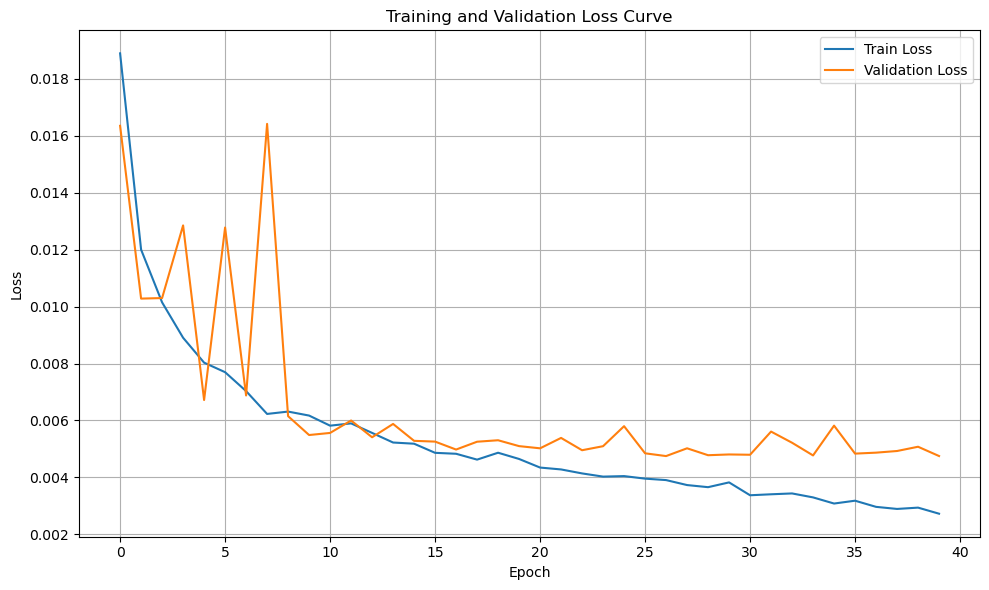

In [6]:
# plot the loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/stereo-resnet18-regression-subset-csv/version_5/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing batch 1 out of 411...
Processing batch 2 out of 411...
Processing batch 3 out of 411...
Processing batch 4 out of 411...
Processing batch 5 out of 411...
Processing batch 6 out of 411...
Processing batch 7 out of 411...
Processing batch 8 out of 411...
Processing batch 9 out of 411...
Processing batch 10 out of 411...
Processing batch 11 out of 411...
Processing batch 12 out of 411...
Processing batch 13 out of 411...
Processing batch 14 out of 411...
Processing batch 15 out of 411...
Processing batch 16 out of 411...
Processing batch 17 out of 411...
Processing batch 18 out of 411...
Processing batch 19 out of 411...
Processing batch 20 out of 411...
R² for rho_eff: 0.98
R² for sa_eff: 0.98


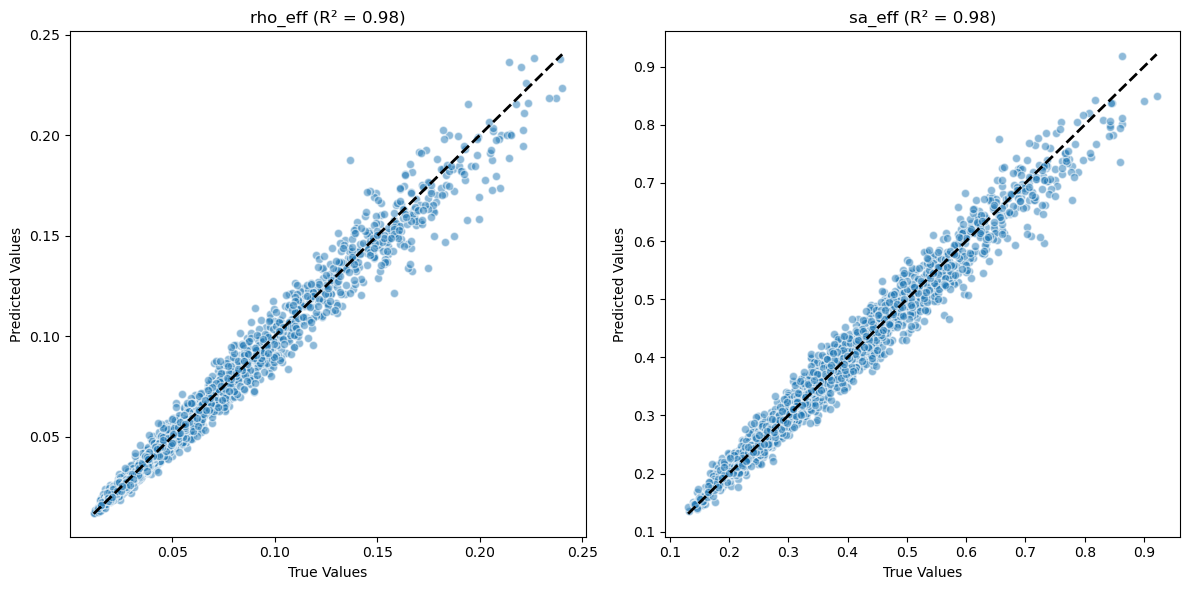

In [8]:
# Set your parameters
hdf_file_1 = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/default.h5'
hdf_file_2 = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/2ds.h5'
batch_size = 64
targets = ['rho_eff', 'sa_eff']  # Replace with your actual target column name
random_state = 666
lr = 5e-4
n_epochs = 40
# num_gpus = torch.cuda.device_count()
num_gpus = 1
num_cpus = 18

# specify train/val/test indices using sklearn
indices = list(range(7_000_000))
train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=random_state)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=random_state)
subset_size = 0.05  # subset percentage

# Input transform: random crop, flip, normalization, etc.
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0]),
])

# validation transform: resize, normalization
val_transform = T.Compose([
    transforms.Normalize(mean=[0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0])
])

# Output transform: log-transform
def log_transform(target):
    # return torch.log1p(target)  # log(1 + x) for numerical stability
    return torch.log(target)  # log(x) for positive values

dm = StereoViewDataModule(
    hdf_file_left=hdf_file_1,
    hdf_file_right=hdf_file_2,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=num_cpus,
    prefetch_factor=4,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=log_transform,
    val_target_transform=log_transform,
    test_target_transform=log_transform
)
dm.setup()

# load model from lightning_logs
model_path = '/glade/u/home/joko/ice3d/models/lightning_logs/stereo-resnet18-regression-subset-csv/version_5/checkpoints/epoch=39-step=153120.ckpt'
model = ResNet18Regression.load_from_checkpoint(
    model_path,
    input_channels=2,
    output_size=len(targets),
    learning_rate=lr
)
model = model.to('cpu')
# Set model to evaluation mode
model.eval()

# Convert test data to PyTorch tensors
test_loader = torch.utils.data.DataLoader(dm.test_dataset, batch_size=128, shuffle=True)
all_preds = []
all_targets = []
n_batches = 20  # Number of batches to process

# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(test_loader)
    for i, batch in enumerate(test_loader):
        if i >= n_batches:  # Stop after 20 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        images, targets = batch
        preds = model(images)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute R² values
r2_rho = r2_score(all_targets[:, 0], all_preds[:, 0])
r2_sa = r2_score(all_targets[:, 1], all_preds[:, 1])
print(f'R² for rho_eff: {r2_rho:.2f}')
print(f'R² for sa_eff: {r2_sa:.2f}')

# Plot scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rho_eff
axes[0].scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.5, edgecolor='white')
axes[0].plot([all_targets[:, 0].min(), all_targets[:, 0].max()],
             [all_targets[:, 0].min(), all_targets[:, 0].max()], 'k--', lw=2)
axes[0].set_title(f'rho_eff (R² = {r2_rho:.2f})')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')

# Scatter plot for sa_eff
axes[1].scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.5, edgecolor='white')
axes[1].plot([all_targets[:, 1].min(), all_targets[:, 1].max()],
             [all_targets[:, 1].min(), all_targets[:, 1].max()], 'k--', lw=2)
axes[1].set_title(f'sa_eff (R² = {r2_sa:.2f})')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

#### PHIPS

### Resnet (classification)

#### 2DS

In [2]:
import sys
sys.path.append('/glade/u/home/joko/ice3d')
from data.stereo_view_dataset import StereoViewDataset
from data.stereo_view_datamodule import StereoViewDataModule
from models.resnet18_classification import ResNet18Classification
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import json

In [5]:
# Set up dataset and dataloader
# Set your parameters
hdf_file_1 = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/sorted/default_sorted.h5'
hdf_file_2 = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/imgs-ml-ready/sorted/2ds_sorted.h5'
batch_size = 128
targets = ['n_arms']  # Replace with your actual target column name
random_state = 666
lr = 1e-3
n_epochs = 20
# num_gpus = torch.cuda.device_count()
num_gpus = 4
num_cpus = 64

# specify train/val/test indices using sklearn
indices = list(range(7_000_000))
train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=random_state)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=random_state)
subset_size = 0.10  # subset percentage

# set up logger information
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'stereo-resnet18-classification-subset-tb'
csv_log_name = f'stereo-resnet18-classification-subset-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)

# Input transform: random crop, flip, normalization, etc.
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0]),
])

# validation transform: resize, normalization
val_transform = T.Compose([
    transforms.Normalize(mean=[0.5, 0.5],       # Zero-mean normalization
                         std=[1.0, 1.0])
])

class_mapping_file = '/glade/u/home/joko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
num_classes = len(class_to_idx)  # Number of unique classes in n_arms

# Instantiate the DataModule
print('instantiate datamodule...')
dm = StereoViewDataModule(
    hdf_file_left=hdf_file_1,
    hdf_file_right=hdf_file_2,
    target_names=targets,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=batch_size,
    subset_size=subset_size,
    subset_seed=random_state,
    num_workers=num_cpus,
    prefetch_factor=32,
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=val_transform,  # Often same as val
    train_target_transform=None,
    val_target_transform=None,
    test_target_transform=None,
    task_type='classification',  # Specify the task type
    class_to_idx=class_to_idx  # Optional: mapping of class names to indices
)

instantiate datamodule...


In [ ]:
%%time
# train model
print('set up model and trainer...')
model = ResNet18Classification(input_channels=2, num_classes=num_classes, learning_rate=lr)

# # load model from lightning_logs
# model_path = '/glade/u/home/joko/ice3d/models/lightning_logs/stereo-resnet18-classification-subset-csv/version_16/checkpoints/epoch=12-step=42108.ckpt'
# model = ResNet18Classification.load_from_checkpoint(
#     model_path,
#     input_channels=2,
#     num_classes=num_classes,
#     learning_rate=lr,
#     map_location='cpu'  # Load model to CPU
# )

trainer = Trainer(max_epochs=n_epochs, 
                  accelerator="auto",
                  devices=num_gpus,
                  strategy="ddp_notebook", # distributed data parallel
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=True)

# train model
print(f'Training model with {num_gpus} gpu(s)...')
trainer.fit(model, dm)
# trainer.fit(model, dm, ckpt_path=model_path)

instantiate datamodule...
set up model and trainer...


/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model with 4 gpu(s)...


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torch/distributed/algorithms/ddp_comm_hooks/__init__.py:54: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  ALLREDUCE = partia

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 19: 100%|██████████| 957/957 [01:15<00:00, 12.74it/s, v_num=17]      

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 957/957 [01:15<00:00, 12.68it/s, v_num=17]
CPU times: user 18.8 s, sys: 10.1 s, total: 29 s
Wall time: 22min 53s


Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


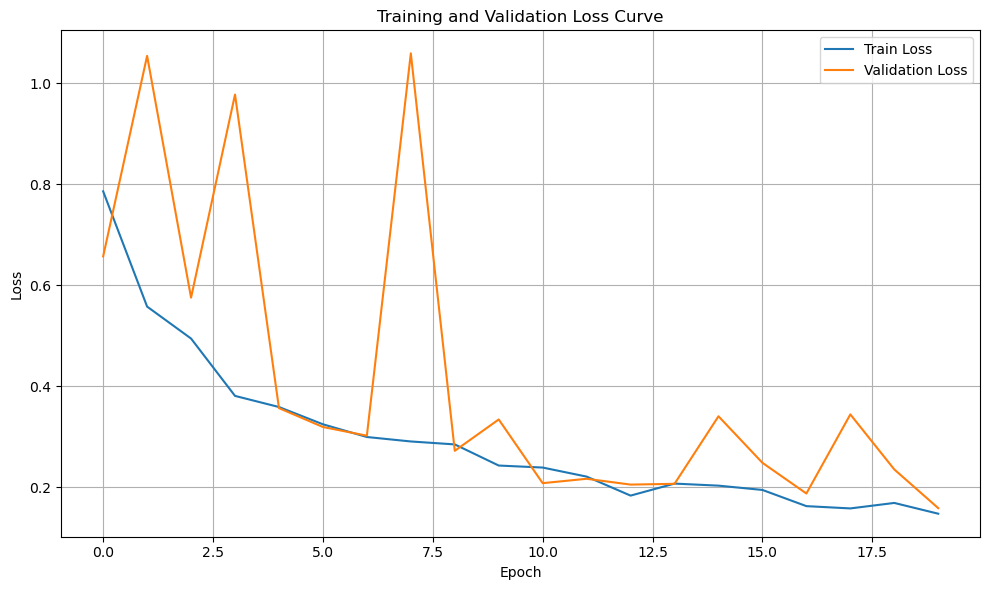

In [4]:
# plot the loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/stereo-resnet18-classification-subset-csv/version_17/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Processing batch 1 out of 821...
Processing batch 2 out of 821...
Processing batch 3 out of 821...
Processing batch 4 out of 821...
Processing batch 5 out of 821...
Processing batch 6 out of 821...
Processing batch 7 out of 821...
Processing batch 8 out of 821...
Processing batch 9 out of 821...
Processing batch 10 out of 821...
Processing batch 11 out of 821...
Processing batch 12 out of 821...
Processing batch 13 out of 821...
Processing batch 14 out of 821...
Processing batch 15 out of 821...
Processing batch 16 out of 821...
Processing batch 17 out of 821...
Processing batch 18 out of 821...
Processing batch 19 out of 821...
Processing batch 20 out of 821...
Accuracy: 0.94


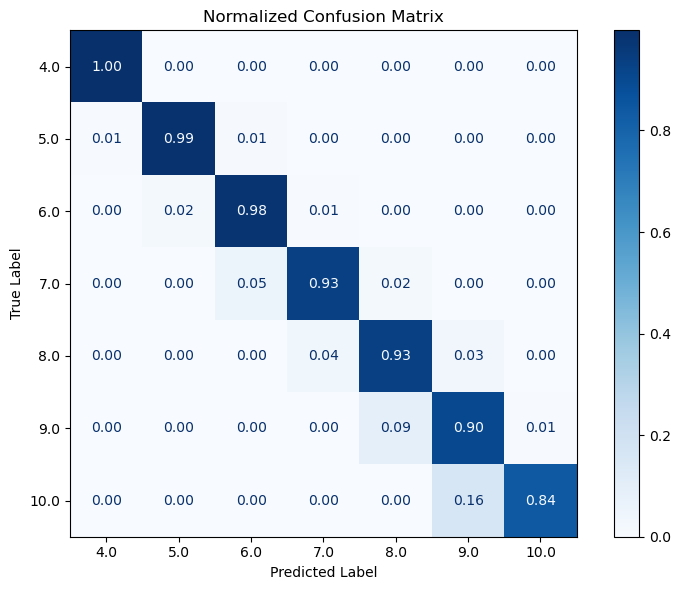

In [6]:
# run inference on test set
# NOTE: must re-instantiate dm to load the test dataset (cell above)
dm.setup()

# load model from lightning_logs
model_path = '/glade/u/home/joko/ice3d/models/lightning_logs/stereo-resnet18-classification-subset-csv/version_17/checkpoints/epoch=19-step=19140.ckpt'
model = ResNet18Classification.load_from_checkpoint(
    model_path,
    input_channels=2,
    num_classes=num_classes,
    learning_rate=lr
)
# model = model.to('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set model to evaluation mode
model.eval()

test_loader = torch.utils.data.DataLoader(dm.test_dataset, batch_size=128, shuffle=True)
all_preds = []
all_targets = []
n_batches = 20  # Number of batches to process
# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(test_loader)
    for i, batch in enumerate(test_loader):
        if i >= n_batches:  # Stop after 20 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        images, targets = batch
        images = images.to(device)
        preds = model(images)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Convert model outputs to predicted class indices
pred_labels = np.argmax(all_preds, axis=1)

# Compute accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_targets, pred_labels)
print(f'Accuracy: {accuracy:.2f}')

# Compute confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(all_targets, pred_labels, normalize='true')
class_labels = list(class_to_idx.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()